In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from datetime import datetime
from tqdm import tqdm
tqdm.pandas()

### Sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier



In [2]:
telemetry_df = pd.read_csv("../data/raw/PdM_telemetry.csv")
failuredf = pd.read_csv("../data/raw/PdM_failures.csv")
errordf = pd.read_csv("../data/raw/PdM_errors.csv")

print(telemetry_df.columns)
print(telemetry_df.shape)
print(telemetry_df.head(3))

print(failuredf.columns)
print(failuredf.shape)
print(failuredf.head(3))

print(errordf.columns)
print(errordf.shape)
print(errordf.head(3))

Index(['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration'], dtype='object')
(876100, 6)
              datetime  machineID        volt      rotate    pressure  \
0  2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1  2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2  2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   

   vibration  
0  45.087686  
1  43.413973  
2  34.178847  
Index(['datetime', 'machineID', 'failure'], dtype='object')
(761, 3)
              datetime  machineID failure
0  2015-01-05 06:00:00          1   comp4
1  2015-03-06 06:00:00          1   comp1
2  2015-04-20 06:00:00          1   comp2
Index(['datetime', 'machineID', 'errorID'], dtype='object')
(3919, 3)
              datetime  machineID errorID
0  2015-01-03 07:00:00          1  error1
1  2015-01-03 20:00:00          1  error3
2  2015-01-04 06:00:00          1  error5


In [3]:
print(telemetry_df.describe())

           machineID           volt         rotate       pressure  \
count  876100.000000  876100.000000  876100.000000  876100.000000   
mean       50.500000     170.777736     446.605119     100.858668   
std        28.866087      15.509114      52.673886      11.048679   
min         1.000000      97.333604     138.432075      51.237106   
25%        25.750000     160.304927     412.305714      93.498181   
50%        50.500000     170.607338     447.558150     100.425559   
75%        75.250000     181.004493     482.176600     107.555231   
max       100.000000     255.124717     695.020984     185.951998   

           vibration  
count  876100.000000  
mean       40.385007  
std         5.370361  
min        14.877054  
25%        36.777299  
50%        40.237247  
75%        43.784938  
max        76.791072  


In [3]:
telemetry_df["datetime"]= telemetry_df["datetime"].progress_apply(lambda x : time.strptime(x, "%Y-%m-%d %H:%M:%S"))
type(telemetry_df["datetime"][0])

100%|██████████| 876100/876100 [00:29<00:00, 29488.85it/s]


time.struct_time

In [4]:
failuredf["datetime"]= failuredf["datetime"].progress_apply(lambda x : time.strptime(x, "%Y-%m-%d %H:%M:%S"))
type(failuredf["datetime"][0])

100%|██████████| 761/761 [00:00<00:00, 21327.30it/s]


time.struct_time

In [5]:
errordf["datetime"]= errordf["datetime"].progress_apply(lambda x : time.strptime(x, "%Y-%m-%d %H:%M:%S"))
type(errordf["datetime"][0])

100%|██████████| 3919/3919 [00:00<00:00, 43617.05it/s]


time.struct_time

In [7]:
telemetry_df.datetime.describe(datetime_is_numeric=True)

count                              876100
unique                               8761
top       (2015, 1, 1, 6, 0, 0, 3, 1, -1)
freq                                  100
Name: datetime, dtype: object

In [98]:
#passage au format pandas timestamp --- optionnel ---
df2['datetime'] = df2["datetime"].apply(lambda x: datetime.fromtimestamp(time.mktime(x)))
type(df2["datetime"][0])

pandas._libs.tslibs.timestamps.Timestamp

In [10]:
telemetry_df.duplicated().sum()


0

In [11]:
telemetry_df.isnull().sum()

datetime     0
machineID    0
volt         0
rotate       0
pressure     0
vibration    0
dtype: int64

In [46]:
telemetry_df.head(5)

,datetime,machineID,volt,rotate,pressure,vibration
0,"(2015, 1, 1, 6, 0, 0, 3, 1, -1)",1,176.217853,418.504078,113.077935,45.087686
1,"(2015, 1, 1, 7, 0, 0, 3, 1, -1)",1,162.879223,402.747490,95.460525,43.413973
2,"(2015, 1, 1, 8, 0, 0, 3, 1, -1)",1,170.989902,527.349825,75.237905,34.178847
3,"(2015, 1, 1, 9, 0, 0, 3, 1, -1)",1,162.462833,346.149335,109.248561,41.122144
4,"(2015, 1, 1, 10, 0, 0, 3, 1, -1)",1,157.610021,435.376873,111.886648,25.990511


In [28]:
errordf["errorID"].value_counts()

error1    1010
error2     988
error3     838
error4     727
error5     356
Name: errorID, dtype: int64

In [35]:
errordf['machineID']=errordf['machineID'].astype(int)

#merge two DataFrames
df = telemetry_df.merge(errordf, left_on=['datetime','machineID'], how='left', right_on = ['datetime','machineID'])

#df = telemetry_df.merge(failuredf, left_on="machineID", right_on='datetime')
df.head()

,datetime,machineID,volt,rotate,pressure,vibration,errorID
0,"(2015, 1, 1, 6, 0, 0, 3, 1, -1)",1,176.217853,418.504078,113.077935,45.087686,NaN
1,"(2015, 1, 1, 7, 0, 0, 3, 1, -1)",1,162.879223,402.747490,95.460525,43.413973,NaN
2,"(2015, 1, 1, 8, 0, 0, 3, 1, -1)",1,170.989902,527.349825,75.237905,34.178847,NaN
3,"(2015, 1, 1, 9, 0, 0, 3, 1, -1)",1,162.462833,346.149335,109.248561,41.122144,NaN
4,"(2015, 1, 1, 10, 0, 0, 3, 1, -1)",1,157.610021,435.376873,111.886648,25.990511,NaN


In [11]:
df.isna().sum()

datetime     0
machineID    0
volt         0
rotate       0
pressure     0
vibration    0
errorID      0
dtype: int64

In [37]:
df.loc[(df.errorID == 'error2') , 'errorID'] = 'error'
df.loc[(df.errorID == 'error1') , 'errorID'] = 'error'
df.loc[(df.errorID == 'error3') , 'errorID'] = 'error'
df.loc[(df.errorID == 'error4') , 'errorID'] = 'error'
df.loc[(df.errorID == 'error5') , 'errorID'] = 'error'


In [41]:
df['errorID'].unique()

array([0., 1.])

In [45]:
type(df['volt'][0])

numpy.float64

In [39]:
df['errorID'] =df['errorID'].fillna("auc_error")

In [40]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
df['errorID']  = ord_enc.fit_transform(df[['errorID']])

In [42]:
corr_rank = df.corr()['errorID'].sort_values()
corr_rank.head(n=15)

rotate      -0.014891
machineID    0.001265
pressure     0.005049
vibration    0.005141
volt         0.006385
errorID      1.000000
Name: errorID, dtype: float64

In [47]:
df["errorID"].value_counts()

0.0    872484
1.0      3919
Name: errorID, dtype: int64

In [56]:
type(df["errorID"][0])

float

In [8]:
df["errorID"]= df["errorID"].progress_apply(lambda x : False if x!= x else True)


100%|██████████| 876403/876403 [00:01<00:00, 583541.59it/s]


In [68]:
df["errorID"].value_counts()

False    872484
True       3919
Name: errorID, dtype: int64

In [43]:
X = df.loc[:,  ~df.columns.isin(['errorID','datetime'])]
y = df["errorID"]
X

,machineID,volt,rotate,pressure,vibration
0,1,176.217853,418.504078,113.077935,45.087686
1,1,162.879223,402.747490,95.460525,43.413973
2,1,170.989902,527.349825,75.237905,34.178847
3,1,162.462833,346.149335,109.248561,41.122144
4,1,157.610021,435.376873,111.886648,25.990511
...,...,...,...,...,...
876398,100,179.438162,395.222827,102.290715,50.771941
876399,100,189.617555,446.207972,98.180607,35.123072
876400,100,192.483414,447.816524,94.132837,48.314561
876401,100,165.475310,413.771670,104.081073,44.835259


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)
#test_size=0.33, random_state=42


In [21]:
y_train.count()

587190

In [ ]:
y_train.groupby(['Genre']).count().plot(kind='pie', y='Lyrics', figsize= (10,10))


In [ ]:
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.pie(y_train, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [15]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.00027131944171820965

In [56]:
clf = SGDClassifier(max_iter=1000, tol=1e-3, class_weight = "balanced").fit(X_train, y_train)


0.46995121242821036

In [64]:
clf.score(X_test, y_test)

0.004436176797031946

In [65]:
y_pred = clf.predict(X_test)

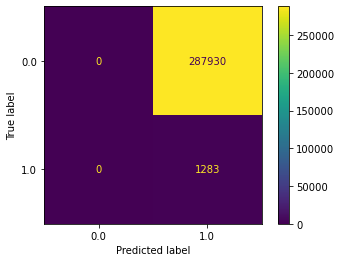

In [66]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()

In [59]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average=None)

array([0.63806207, 0.01022721])

In [63]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline 

# Définition de l'instance SMOTE
sm = SMOTE(sampling_strategy=0.75)
#to_model_columns= X_train.columns[::-1]
#X, y = X_train[to_model_columns], X_train.errorID

# define resampling
#oversampling des machines fonctionnelles
over = SMOTE(sampling_strategy=0.1)
#undersampling des machines défaillantes
under = RandomUnderSampler(sampling_strategy=0.5)

# SVC
#clf = SVC(gamma='auto')

# Application du SMOTE aux données
X_train, Y_train = sm.fit_resample(X, y)
clf.fit(X_train, Y_train)

SGDClassifier(class_weight='balanced')

## IMBLearn

In [21]:
from imblearn.datasets import make_imbalance
from imblearn.metrics import classification_report_imbalanced
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import NearMiss

In [22]:

# Classify and report the results
print(classification_report_imbalanced(y_test, clf.predict(X_test)))

/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.00      0.00      1.00      0.00      0.00      0.00       315
        1.0       0.00      0.00      1.00      0.00      0.00      0.00       329
        2.0       0.00      0.00      1.00      0.00      0.00      0.00       291
        3.0       0.00      0.00      1.00      0.00      0.00      0.00       237
        4.0       0.00      0.00      1.00      0.00      0.00      0.00       111
        5.0       1.00      1.00      0.00      1.00      0.00      0.00    287930

avg / total       0.99      1.00      0.00      0.99      0.00      0.00    289213



### Problème de classes: wj=n_samples / (n_classes * n_samplesj)

In [73]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=None, random_state=41,class_weight = {0: 0.1, 1: 0.9}).fit(X_train, y_train)
rfc.score(X_test, y_test)

0.9960513531549412

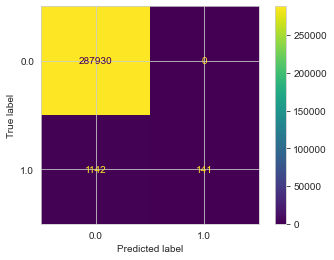

In [74]:
y_pred = rfc.predict(X_test)
cm_rfc = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rfc,display_labels=rfc.classes_)
disp.plot()

In [44]:
from sklearn.linear_model import LogisticRegression

print(LogisticRegression(random_state=0).fit(X,y).predict(X).mean()) # 0.184
print((LogisticRegression(random_state=0).fit(X,y).predict_proba(X)[:,1]>0.5).mean()) # 0.184 => same as first
print(LogisticRegression(random_state=0,class_weight={0:0.5,1:0.5}).fit(X,y).predict(X).mean()) # 0.184 => same as first
print(LogisticRegression(random_state=0,class_weight={0:2,1:8}).fit(X,y).predict(X).mean()) # 0.296 => seems to make things worse?
print(LogisticRegression(random_state=0,class_weight="balanced").fit(X,y).predict(X).mean()) # 0.292 => seems to make things worse?


0.0
0.0
0.0
0.0
0.44383691064498865


In [ ]:
mask = (df2['datetime'] >= time.strptime('2015-01-01 06:00:00', "%Y-%m-%d %H:%M:%S")) & (df2['datetime'] < time.strptime('2015-01-29 23:00:00', "%Y-%m-%d %H:%M:%S"))

month = df2[mask]
print(month)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END ......................class_weight={0: 0.0, 1: 1.0}; total time=   4.1s
[CV] END ......................class_weight={0: 0.0, 1: 1.0}; total time=   4.1s
[CV] END ......................class_weight={0: 0.0, 1: 1.0}; total time=   4.3s
[CV] END ......................class_weight={0: 0.0, 1: 1.0}; total time=   4.5s
[CV] END class_weight={0: 0.004974874371859297, 1: 0.9950251256281407}; total time=   4.5s
[CV] END ......................class_weight={0: 0.0, 1: 1.0}; total time=   4.6s
[CV] END class_weight={0: 0.004974874371859297, 1: 0.9950251256281407}; total time=   4.4s
[CV] END class_weight={0: 0.004974874371859297, 1: 0.9950251256281407}; total time=   5.3s
[CV] END class_weight={0: 0.004974874371859297, 1: 0.9950251256281407}; total time=   3.8s
[CV] END class_weight={0: 0.004974874371859297, 1: 0.9950251256281407}; total time=   5.2s
[CV] END class_weight={0: 0.009949748743718593, 1: 0.9900502512562814}; tota

/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.009949748743718593, 1: 0.9900502512562814}; total time=  17.9s
[CV] END class_weight={0: 0.014924623115577889, 1: 0.9850753768844221}; total time=  16.2s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.014924623115577889, 1: 0.9850753768844221}; total time=  33.0s
[CV] END class_weight={0: 0.014924623115577889, 1: 0.9850753768844221}; total time=  26.8s
[CV] END class_weight={0: 0.019899497487437186, 1: 0.9801005025125629}; total time=  22.7s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.014924623115577889, 1: 0.9850753768844221}; total time=  35.0s
[CV] END class_weight={0: 0.019899497487437186, 1: 0.9801005025125629}; total time=  28.1s
[CV] END class_weight={0: 0.019899497487437186, 1: 0.9801005025125629}; total time=  25.9s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.019899497487437186, 1: 0.9801005025125629}; total time=  31.1s
[CV] END class_weight={0: 0.019899497487437186, 1: 0.9801005025125629}; total time=  20.6s
[CV] END class_weight={0: 0.024874371859296484, 1: 0.9751256281407035}; total time=  14.1s
[CV] END class_weight={0: 0.024874371859296484, 1: 0.9751256281407035}; total time=  16.3s
[CV] END class_weight={0: 0.024874371859296484, 1: 0.9751256281407035}; total time=  15.7s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.024874371859296484, 1: 0.9751256281407035}; total time=  25.2s
[CV] END class_weight={0: 0.024874371859296484, 1: 0.9751256281407035}; total time=  19.2s
[CV] END class_weight={0: 0.029849246231155778, 1: 0.9701507537688442}; total time=  20.5s
[CV] END class_weight={0: 0.029849246231155778, 1: 0.9701507537688442}; total time=  18.4s
[CV] END class_weight={0: 0.029849246231155778, 1: 0.9701507537688442}; total time=  17.9s
[CV] END class_weight={0: 0.034824120603015075, 1: 0.9651758793969849}; total time=  23.0s
[CV] END class_weight={0: 0.029849246231155778, 1: 0.9701507537688442}; total time=  24.7s
[CV] END class_weight={0: 0.029849246231155778, 1: 0.9701507537688442}; total time=  25.4s
[CV] END class_weight={0: 0.034824120603015075, 1: 0.9651758793969849}; total time=  26.0s
[CV] END class_weight={0: 0.034824120603015075, 1: 0.9651758793969849}; total time=  17.4s
[CV] END class_weight={0: 0.034824120603015075, 1: 0.9651758793969849}; total time=  17.7s

/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.059698492462311556, 1: 0.9403015075376885}; total time=  19.3s
[CV] END class_weight={0: 0.06467336683417085, 1: 0.9353266331658292}; total time=  12.1s
[CV] END class_weight={0: 0.06467336683417085, 1: 0.9353266331658292}; total time=  14.7s
[CV] END class_weight={0: 0.06467336683417085, 1: 0.9353266331658292}; total time=  13.3s
[CV] END class_weight={0: 0.06467336683417085, 1: 0.9353266331658292}; total time=  15.9s
[CV] END class_weight={0: 0.06467336683417085, 1: 0.9353266331658292}; total time=  14.7s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.06964824120603015, 1: 0.9303517587939698}; total time=  19.2s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.06964824120603015, 1: 0.9303517587939698}; total time=  16.2s
[CV] END class_weight={0: 0.06964824120603015, 1: 0.9303517587939698}; total time=  14.6s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.06964824120603015, 1: 0.9303517587939698}; total time=  17.0s
[CV] END class_weight={0: 0.06964824120603015, 1: 0.9303517587939698}; total time=  14.3s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.07462311557788945, 1: 0.9253768844221105}; total time=  17.6s
[CV] END class_weight={0: 0.07462311557788945, 1: 0.9253768844221105}; total time=  14.7s
[CV] END class_weight={0: 0.07462311557788945, 1: 0.9253768844221105}; total time=  15.7s
[CV] END class_weight={0: 0.07959798994974875, 1: 0.9204020100502512}; total time=  13.9s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.07462311557788945, 1: 0.9253768844221105}; total time=  21.6s
[CV] END class_weight={0: 0.07462311557788945, 1: 0.9253768844221105}; total time=  15.3s
[CV] END class_weight={0: 0.07959798994974875, 1: 0.9204020100502512}; total time=  15.4s
[CV] END class_weight={0: 0.07959798994974875, 1: 0.9204020100502512}; total time=  15.4s
[CV] END class_weight={0: 0.07959798994974875, 1: 0.9204020100502512}; total time=  15.1s
[CV] END class_weight={0: 0.07959798994974875, 1: 0.9204020100502512}; total time=  15.5s
[CV] END class_weight={0: 0.08457286432160804, 1: 0.915427135678392}; total time=  14.2s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.08457286432160804, 1: 0.915427135678392}; total time=  15.3s
[CV] END class_weight={0: 0.08457286432160804, 1: 0.915427135678392}; total time=  14.9s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.08457286432160804, 1: 0.915427135678392}; total time=  18.4s
[CV] END class_weight={0: 0.08457286432160804, 1: 0.915427135678392}; total time=  14.7s
[CV] END class_weight={0: 0.08954773869346734, 1: 0.9104522613065327}; total time=  16.2s
[CV] END class_weight={0: 0.08954773869346734, 1: 0.9104522613065327}; total time=  13.8s
[CV] END class_weight={0: 0.08954773869346734, 1: 0.9104522613065327}; total time=  15.1s
[CV] END class_weight={0: 0.08954773869346734, 1: 0.9104522613065327}; total time=  18.7s
[CV] END class_weight={0: 0.08954773869346734, 1: 0.9104522613065327}; total time=  16.7s
[CV] END class_weight={0: 0.09452261306532664, 1: 0.9054773869346734}; total time=  15.9s
[CV] END class_weight={0: 0.09452261306532664, 1: 0.9054773869346734}; total time=  18.3s
[CV] END class_weight={0: 0.09452261306532664, 1: 0.9054773869346734}; total time=  17.9s
[CV] END class_weight={0: 0.09949748743718594, 1: 0.9005025125628141}; total time=  14.0s
[CV] END cla

/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.09949748743718594, 1: 0.9005025125628141}; total time=  22.4s
[CV] END class_weight={0: 0.10447236180904523, 1: 0.8955276381909547}; total time=  13.2s
[CV] END class_weight={0: 0.10447236180904523, 1: 0.8955276381909547}; total time=  17.4s
[CV] END class_weight={0: 0.10447236180904523, 1: 0.8955276381909547}; total time=  17.6s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.10447236180904523, 1: 0.8955276381909547}; total time=  19.0s
[CV] END class_weight={0: 0.10944723618090453, 1: 0.8905527638190954}; total time=  16.2s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.10944723618090453, 1: 0.8905527638190954}; total time=  19.5s
[CV] END class_weight={0: 0.10944723618090453, 1: 0.8905527638190954}; total time=  15.6s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.10944723618090453, 1: 0.8905527638190954}; total time=  18.5s
[CV] END class_weight={0: 0.10944723618090453, 1: 0.8905527638190954}; total time=  14.1s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.11442211055276383, 1: 0.8855778894472361}; total time=  14.2s
[CV] END class_weight={0: 0.11442211055276383, 1: 0.8855778894472361}; total time=  19.4s
[CV] END class_weight={0: 0.11442211055276383, 1: 0.8855778894472361}; total time=  15.8s
[CV] END class_weight={0: 0.11442211055276383, 1: 0.8855778894472361}; total time=  15.6s
[CV] END class_weight={0: 0.11939698492462311, 1: 0.8806030150753769}; total time=  12.9s
[CV] END class_weight={0: 0.11442211055276383, 1: 0.8855778894472361}; total time=  14.0s
[CV] END class_weight={0: 0.11939698492462311, 1: 0.8806030150753769}; total time=  13.6s
[CV] END class_weight={0: 0.11939698492462311, 1: 0.8806030150753769}; total time=  15.3s
[CV] END class_weight={0: 0.12437185929648241, 1: 0.8756281407035176}; total time=  15.0s
[CV] END class_weight={0: 0.11939698492462311, 1: 0.8806030150753769}; total time=  16.7s
[CV] END class_weight={0: 0.12437185929648241, 1: 0.8756281407035176}; total time=  15.5s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.11939698492462311, 1: 0.8806030150753769}; total time=  19.9s
[CV] END class_weight={0: 0.12437185929648241, 1: 0.8756281407035176}; total time=  15.1s
[CV] END class_weight={0: 0.12437185929648241, 1: 0.8756281407035176}; total time=  21.5s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.12437185929648241, 1: 0.8756281407035176}; total time=  20.7s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.1293467336683417, 1: 0.8706532663316583}; total time=  22.0s
[CV] END class_weight={0: 0.1293467336683417, 1: 0.8706532663316583}; total time=  13.9s
[CV] END class_weight={0: 0.1293467336683417, 1: 0.8706532663316583}; total time=  13.4s
[CV] END class_weight={0: 0.1293467336683417, 1: 0.8706532663316583}; total time=  15.1s
[CV] END class_weight={0: 0.1293467336683417, 1: 0.8706532663316583}; total time=  14.0s
[CV] END class_weight={0: 0.13432160804020102, 1: 0.865678391959799}; total time=  15.8s
[CV] END class_weight={0: 0.13432160804020102, 1: 0.865678391959799}; total time=  14.5s
[CV] END class_weight={0: 0.13432160804020102, 1: 0.865678391959799}; total time=  13.0s
[CV] END class_weight={0: 0.13432160804020102, 1: 0.865678391959799}; total time=  18.3s
[CV] END class_weight={0: 0.1392964824120603, 1: 0.8607035175879397}; total time=  14.3s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.13432160804020102, 1: 0.865678391959799}; total time=  19.7s
[CV] END class_weight={0: 0.1392964824120603, 1: 0.8607035175879397}; total time=  16.3s
[CV] END class_weight={0: 0.1392964824120603, 1: 0.8607035175879397}; total time=  16.3s
[CV] END class_weight={0: 0.1392964824120603, 1: 0.8607035175879397}; total time=  15.1s
[CV] END class_weight={0: 0.1392964824120603, 1: 0.8607035175879397}; total time=  15.9s
[CV] END class_weight={0: 0.1442713567839196, 1: 0.8557286432160804}; total time=  14.7s
[CV] END class_weight={0: 0.1442713567839196, 1: 0.8557286432160804}; total time=  15.8s
[CV] END class_weight={0: 0.1442713567839196, 1: 0.8557286432160804}; total time=  16.6s
[CV] END class_weight={0: 0.1442713567839196, 1: 0.8557286432160804}; total time=  12.7s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.1442713567839196, 1: 0.8557286432160804}; total time=  15.9s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.1492462311557789, 1: 0.850753768844221}; total time=  15.7s
[CV] END class_weight={0: 0.1492462311557789, 1: 0.850753768844221}; total time=  15.0s
[CV] END class_weight={0: 0.1492462311557789, 1: 0.850753768844221}; total time=  15.4s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.1492462311557789, 1: 0.850753768844221}; total time=  17.2s
[CV] END class_weight={0: 0.1492462311557789, 1: 0.850753768844221}; total time=  13.2s
[CV] END class_weight={0: 0.1542211055276382, 1: 0.8457788944723618}; total time=  12.9s
[CV] END class_weight={0: 0.1542211055276382, 1: 0.8457788944723618}; total time=  13.4s
[CV] END class_weight={0: 0.1542211055276382, 1: 0.8457788944723618}; total time=  16.7s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.1542211055276382, 1: 0.8457788944723618}; total time=  20.8s
[CV] END class_weight={0: 0.1542211055276382, 1: 0.8457788944723618}; total time=  16.8s
[CV] END class_weight={0: 0.1591959798994975, 1: 0.8408040201005025}; total time=  17.3s
[CV] END class_weight={0: 0.1591959798994975, 1: 0.8408040201005025}; total time=  15.3s
[CV] END class_weight={0: 0.1591959798994975, 1: 0.8408040201005025}; total time=  16.2s
[CV] END class_weight={0: 0.1591959798994975, 1: 0.8408040201005025}; total time=  16.0s
[CV] END class_weight={0: 0.1591959798994975, 1: 0.8408040201005025}; total time=  16.0s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.16417085427135678, 1: 0.8358291457286432}; total time=  18.1s
[CV] END class_weight={0: 0.16417085427135678, 1: 0.8358291457286432}; total time=  13.1s
[CV] END class_weight={0: 0.16417085427135678, 1: 0.8358291457286432}; total time=  15.2s
[CV] END class_weight={0: 0.16417085427135678, 1: 0.8358291457286432}; total time=  16.6s
[CV] END class_weight={0: 0.1691457286432161, 1: 0.8308542713567839}; total time=  12.2s
[CV] END class_weight={0: 0.16417085427135678, 1: 0.8358291457286432}; total time=  15.3s
[CV] END class_weight={0: 0.1691457286432161, 1: 0.8308542713567839}; total time=  12.1s
[CV] END class_weight={0: 0.1691457286432161, 1: 0.8308542713567839}; total time=  16.8s
[CV] END class_weight={0: 0.1691457286432161, 1: 0.8308542713567839}; total time=  15.6s
[CV] END class_weight={0: 0.1691457286432161, 1: 0.8308542713567839}; total time=  17.9s
[CV] END class_weight={0: 0.17412060301507537, 1: 0.8258793969849246}; total time=  11.9s
[CV] END class_

/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.17909547738693468, 1: 0.8209045226130653}; total time=  21.7s
[CV] END class_weight={0: 0.17909547738693468, 1: 0.8209045226130653}; total time=  28.4s
[CV] END class_weight={0: 0.18407035175879397, 1: 0.8159296482412061}; total time=  27.2s
[CV] END class_weight={0: 0.18407035175879397, 1: 0.8159296482412061}; total time=  29.3s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.18407035175879397, 1: 0.8159296482412061}; total time=  24.1s
[CV] END class_weight={0: 0.18407035175879397, 1: 0.8159296482412061}; total time=  15.6s
[CV] END class_weight={0: 0.18904522613065328, 1: 0.8109547738693468}; total time=  15.7s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.18407035175879397, 1: 0.8159296482412061}; total time=  27.0s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.18904522613065328, 1: 0.8109547738693468}; total time=  22.4s
[CV] END class_weight={0: 0.18904522613065328, 1: 0.8109547738693468}; total time=  21.7s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.18904522613065328, 1: 0.8109547738693468}; total time=  25.5s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.18904522613065328, 1: 0.8109547738693468}; total time=  24.8s
[CV] END class_weight={0: 0.19402010050251256, 1: 0.8059798994974874}; total time=  20.5s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.19402010050251256, 1: 0.8059798994974874}; total time=  21.4s
[CV] END class_weight={0: 0.19402010050251256, 1: 0.8059798994974874}; total time=  21.9s
[CV] END class_weight={0: 0.19402010050251256, 1: 0.8059798994974874}; total time=  24.2s
[CV] END class_weight={0: 0.19402010050251256, 1: 0.8059798994974874}; total time=  25.2s
[CV] END class_weight={0: 0.19899497487437187, 1: 0.8010050251256281}; total time=  19.3s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.19899497487437187, 1: 0.8010050251256281}; total time=  18.5s
[CV] END class_weight={0: 0.19899497487437187, 1: 0.8010050251256281}; total time=  16.9s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.20396984924623116, 1: 0.7960301507537688}; total time=  19.3s
[CV] END class_weight={0: 0.19899497487437187, 1: 0.8010050251256281}; total time=  24.9s
[CV] END class_weight={0: 0.19899497487437187, 1: 0.8010050251256281}; total time=  25.0s
[CV] END class_weight={0: 0.20396984924623116, 1: 0.7960301507537688}; total time=  18.3s
[CV] END class_weight={0: 0.20396984924623116, 1: 0.7960301507537688}; total time=  20.4s
[CV] END class_weight={0: 0.20396984924623116, 1: 0.7960301507537688}; total time=  21.4s
[CV] END class_weight={0: 0.20396984924623116, 1: 0.7960301507537688}; total time=  21.8s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.20894472361809047, 1: 0.7910552763819095}; total time=  25.0s
[CV] END class_weight={0: 0.20894472361809047, 1: 0.7910552763819095}; total time=  20.2s
[CV] END class_weight={0: 0.20894472361809047, 1: 0.7910552763819095}; total time=  19.8s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.20894472361809047, 1: 0.7910552763819095}; total time=  20.9s
[CV] END class_weight={0: 0.20894472361809047, 1: 0.7910552763819095}; total time=  19.5s
[CV] END class_weight={0: 0.21391959798994975, 1: 0.7860804020100502}; total time=  21.2s
[CV] END class_weight={0: 0.21391959798994975, 1: 0.7860804020100502}; total time=  23.8s
[CV] END class_weight={0: 0.21391959798994975, 1: 0.7860804020100502}; total time=  24.0s
[CV] END class_weight={0: 0.21391959798994975, 1: 0.7860804020100502}; total time=  21.0s
[CV] END class_weight={0: 0.21391959798994975, 1: 0.7860804020100502}; total time=  28.0s
[CV] END class_weight={0: 0.21889447236180906, 1: 0.781105527638191}; total time=  27.3s
[CV] END class_weight={0: 0.21889447236180906, 1: 0.781105527638191}; total time=  29.1s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.21889447236180906, 1: 0.781105527638191}; total time=  41.0s
[CV] END class_weight={0: 0.21889447236180906, 1: 0.781105527638191}; total time=  25.9s
[CV] END class_weight={0: 0.21889447236180906, 1: 0.781105527638191}; total time=  28.1s
[CV] END class_weight={0: 0.22386934673366835, 1: 0.7761306532663317}; total time=  23.6s
[CV] END class_weight={0: 0.22386934673366835, 1: 0.7761306532663317}; total time=  24.6s
[CV] END class_weight={0: 0.22386934673366835, 1: 0.7761306532663317}; total time=  29.8s
[CV] END class_weight={0: 0.22386934673366835, 1: 0.7761306532663317}; total time=  27.7s
[CV] END class_weight={0: 0.22386934673366835, 1: 0.7761306532663317}; total time=  25.8s
[CV] END class_weight={0: 0.22884422110552766, 1: 0.7711557788944723}; total time=  19.5s
[CV] END class_weight={0: 0.22884422110552766, 1: 0.7711557788944723}; total time=  13.9s
[CV] END class_weight={0: 0.22884422110552766, 1: 0.7711557788944723}; total time=  13.5s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.22884422110552766, 1: 0.7711557788944723}; total time=  16.6s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.22884422110552766, 1: 0.7711557788944723}; total time=  13.9s
[CV] END class_weight={0: 0.23381909547738694, 1: 0.7661809045226131}; total time=  14.0s
[CV] END class_weight={0: 0.23381909547738694, 1: 0.7661809045226131}; total time=  13.9s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.23381909547738694, 1: 0.7661809045226131}; total time=  14.4s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.23381909547738694, 1: 0.7661809045226131}; total time=  16.7s
[CV] END class_weight={0: 0.23381909547738694, 1: 0.7661809045226131}; total time=  13.3s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.23879396984924622, 1: 0.7612060301507537}; total time=  16.8s
[CV] END class_weight={0: 0.23879396984924622, 1: 0.7612060301507537}; total time=  12.4s
[CV] END class_weight={0: 0.23879396984924622, 1: 0.7612060301507537}; total time=  13.9s
[CV] END class_weight={0: 0.23879396984924622, 1: 0.7612060301507537}; total time=  12.9s
[CV] END class_weight={0: 0.24376884422110554, 1: 0.7562311557788944}; total time=  12.1s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.23879396984924622, 1: 0.7612060301507537}; total time=  15.0s
[CV] END class_weight={0: 0.24376884422110554, 1: 0.7562311557788944}; total time=  12.9s
[CV] END class_weight={0: 0.24376884422110554, 1: 0.7562311557788944}; total time=  19.3s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.24376884422110554, 1: 0.7562311557788944}; total time=  18.5s
[CV] END class_weight={0: 0.24376884422110554, 1: 0.7562311557788944}; total time=  20.8s
[CV] END class_weight={0: 0.24874371859296482, 1: 0.7512562814070352}; total time=  24.2s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.24874371859296482, 1: 0.7512562814070352}; total time=  33.6s
[CV] END class_weight={0: 0.24874371859296482, 1: 0.7512562814070352}; total time=  24.6s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.24874371859296482, 1: 0.7512562814070352}; total time=  33.3s
[CV] END class_weight={0: 0.25371859296482413, 1: 0.7462814070351759}; total time=  23.4s
[CV] END class_weight={0: 0.25371859296482413, 1: 0.7462814070351759}; total time=  20.0s
[CV] END class_weight={0: 0.25371859296482413, 1: 0.7462814070351759}; total time=  15.1s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.24874371859296482, 1: 0.7512562814070352}; total time=  30.8s
[CV] END class_weight={0: 0.25371859296482413, 1: 0.7462814070351759}; total time=  14.9s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.25371859296482413, 1: 0.7462814070351759}; total time=  19.4s
[CV] END class_weight={0: 0.2586934673366834, 1: 0.7413065326633166}; total time=  19.3s
[CV] END class_weight={0: 0.2586934673366834, 1: 0.7413065326633166}; total time=  19.7s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.2586934673366834, 1: 0.7413065326633166}; total time=  20.6s
[CV] END class_weight={0: 0.2586934673366834, 1: 0.7413065326633166}; total time=  19.1s
[CV] END class_weight={0: 0.2636683417085427, 1: 0.7363316582914573}; total time=  17.0s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.2586934673366834, 1: 0.7413065326633166}; total time=  21.9s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.2636683417085427, 1: 0.7363316582914573}; total time=  16.4s
[CV] END class_weight={0: 0.2636683417085427, 1: 0.7363316582914573}; total time=  13.7s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.2636683417085427, 1: 0.7363316582914573}; total time=  14.0s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.2636683417085427, 1: 0.7363316582914573}; total time=  17.5s
[CV] END class_weight={0: 0.26864321608040204, 1: 0.731356783919598}; total time=  13.9s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.26864321608040204, 1: 0.731356783919598}; total time=  14.4s
[CV] END class_weight={0: 0.26864321608040204, 1: 0.731356783919598}; total time=  18.3s
[CV] END class_weight={0: 0.26864321608040204, 1: 0.731356783919598}; total time=  14.3s
[CV] END class_weight={0: 0.2736180904522613, 1: 0.7263819095477386}; total time=  13.4s
[CV] END class_weight={0: 0.26864321608040204, 1: 0.731356783919598}; total time=  15.2s
[CV] END class_weight={0: 0.2736180904522613, 1: 0.7263819095477386}; total time=  14.2s
[CV] END class_weight={0: 0.2736180904522613, 1: 0.7263819095477386}; total time=  11.4s
[CV] END class_weight={0: 0.2736180904522613, 1: 0.7263819095477386}; total time=  13.0s
[CV] END class_weight={0: 0.2785929648241206, 1: 0.7214070351758795}; total time=  12.4s
[CV] END class_weight={0: 0.2736180904522613, 1: 0.7263819095477386}; total time=  15.1s
[CV] END class_weight={0: 0.2785929648241206, 1: 0.7214070351758795}; total time=  12.2s
[CV] END class_weight

/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.2785929648241206, 1: 0.7214070351758795}; total time=  17.6s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.2835678391959799, 1: 0.7164321608040201}; total time=  15.4s
[CV] END class_weight={0: 0.2835678391959799, 1: 0.7164321608040201}; total time=  12.4s
[CV] END class_weight={0: 0.2835678391959799, 1: 0.7164321608040201}; total time=  15.2s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.2835678391959799, 1: 0.7164321608040201}; total time=  13.7s
[CV] END class_weight={0: 0.2885427135678392, 1: 0.7114572864321608}; total time=  14.9s
[CV] END class_weight={0: 0.2885427135678392, 1: 0.7114572864321608}; total time=  15.1s
[CV] END class_weight={0: 0.2885427135678392, 1: 0.7114572864321608}; total time=  17.3s
[CV] END class_weight={0: 0.2885427135678392, 1: 0.7114572864321608}; total time=  15.8s
[CV] END class_weight={0: 0.2885427135678392, 1: 0.7114572864321608}; total time=  11.6s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.2935175879396985, 1: 0.7064824120603015}; total time=  14.6s
[CV] END class_weight={0: 0.2935175879396985, 1: 0.7064824120603015}; total time=  13.3s
[CV] END class_weight={0: 0.2935175879396985, 1: 0.7064824120603015}; total time=  13.7s
[CV] END class_weight={0: 0.2935175879396985, 1: 0.7064824120603015}; total time=  12.4s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.2935175879396985, 1: 0.7064824120603015}; total time=  16.0s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.2984924623115578, 1: 0.7015075376884422}; total time=  16.6s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.2984924623115578, 1: 0.7015075376884422}; total time=  17.9s
[CV] END class_weight={0: 0.2984924623115578, 1: 0.7015075376884422}; total time=  12.1s
[CV] END class_weight={0: 0.2984924623115578, 1: 0.7015075376884422}; total time=  14.7s
[CV] END class_weight={0: 0.3034673366834171, 1: 0.6965326633165829}; total time=  11.5s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.2984924623115578, 1: 0.7015075376884422}; total time=  15.6s
[CV] END class_weight={0: 0.3034673366834171, 1: 0.6965326633165829}; total time=  14.8s
[CV] END class_weight={0: 0.3034673366834171, 1: 0.6965326633165829}; total time=  15.5s
[CV] END class_weight={0: 0.3034673366834171, 1: 0.6965326633165829}; total time=  16.8s
[CV] END class_weight={0: 0.3084422110552764, 1: 0.6915577889447235}; total time=  13.3s
[CV] END class_weight={0: 0.3034673366834171, 1: 0.6965326633165829}; total time=  16.4s
[CV] END class_weight={0: 0.3084422110552764, 1: 0.6915577889447235}; total time=  12.1s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.3084422110552764, 1: 0.6915577889447235}; total time=  12.8s
[CV] END class_weight={0: 0.3084422110552764, 1: 0.6915577889447235}; total time=  16.3s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.3084422110552764, 1: 0.6915577889447235}; total time=  21.5s
[CV] END class_weight={0: 0.3134170854271357, 1: 0.6865829145728644}; total time=  13.2s
[CV] END class_weight={0: 0.3134170854271357, 1: 0.6865829145728644}; total time=  13.7s
[CV] END class_weight={0: 0.3134170854271357, 1: 0.6865829145728644}; total time=  14.5s
[CV] END class_weight={0: 0.3134170854271357, 1: 0.6865829145728644}; total time=  11.5s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.3134170854271357, 1: 0.6865829145728644}; total time=  14.4s
[CV] END class_weight={0: 0.318391959798995, 1: 0.681608040201005}; total time=  13.3s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.318391959798995, 1: 0.681608040201005}; total time=  16.4s
[CV] END class_weight={0: 0.318391959798995, 1: 0.681608040201005}; total time=  15.2s
[CV] END class_weight={0: 0.318391959798995, 1: 0.681608040201005}; total time=  11.2s
[CV] END class_weight={0: 0.318391959798995, 1: 0.681608040201005}; total time=  15.4s
[CV] END class_weight={0: 0.32336683417085427, 1: 0.6766331658291458}; total time=  11.1s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.32336683417085427, 1: 0.6766331658291458}; total time=  17.7s
[CV] END class_weight={0: 0.32336683417085427, 1: 0.6766331658291458}; total time=  15.5s
[CV] END class_weight={0: 0.32336683417085427, 1: 0.6766331658291458}; total time=  14.2s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.32336683417085427, 1: 0.6766331658291458}; total time=  18.9s
[CV] END class_weight={0: 0.32834170854271355, 1: 0.6716582914572864}; total time=  18.1s
[CV] END class_weight={0: 0.32834170854271355, 1: 0.6716582914572864}; total time=  17.1s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.32834170854271355, 1: 0.6716582914572864}; total time=  20.2s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.32834170854271355, 1: 0.6716582914572864}; total time=  27.6s
[CV] END class_weight={0: 0.32834170854271355, 1: 0.6716582914572864}; total time=  14.9s
[CV] END class_weight={0: 0.3333165829145729, 1: 0.6666834170854271}; total time=  15.1s
[CV] END class_weight={0: 0.3333165829145729, 1: 0.6666834170854271}; total time=  14.9s
[CV] END class_weight={0: 0.3333165829145729, 1: 0.6666834170854271}; total time=  13.4s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.3333165829145729, 1: 0.6666834170854271}; total time=  16.4s
[CV] END class_weight={0: 0.3333165829145729, 1: 0.6666834170854271}; total time=  14.2s
[CV] END class_weight={0: 0.3382914572864322, 1: 0.6617085427135678}; total time=  14.1s
[CV] END class_weight={0: 0.3382914572864322, 1: 0.6617085427135678}; total time=  14.8s
[CV] END class_weight={0: 0.3382914572864322, 1: 0.6617085427135678}; total time=  16.5s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.3382914572864322, 1: 0.6617085427135678}; total time=  16.8s
[CV] END class_weight={0: 0.34326633165829146, 1: 0.6567336683417085}; total time=  13.3s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.3382914572864322, 1: 0.6617085427135678}; total time=  17.7s
[CV] END class_weight={0: 0.34326633165829146, 1: 0.6567336683417085}; total time=  13.2s
[CV] END class_weight={0: 0.34326633165829146, 1: 0.6567336683417085}; total time=  13.7s
[CV] END class_weight={0: 0.34326633165829146, 1: 0.6567336683417085}; total time=  17.2s
[CV] END class_weight={0: 0.34326633165829146, 1: 0.6567336683417085}; total time=  14.9s
[CV] END class_weight={0: 0.34824120603015074, 1: 0.6517587939698493}; total time=  14.3s
[CV] END class_weight={0: 0.34824120603015074, 1: 0.6517587939698493}; total time=  17.6s
[CV] END class_weight={0: 0.34824120603015074, 1: 0.6517587939698493}; total time=  13.1s
[CV] END class_weight={0: 0.34824120603015074, 1: 0.6517587939698493}; total time=  11.9s
[CV] END class_weight={0: 0.34824120603015074, 1: 0.6517587939698493}; total time=  13.6s
[CV] END class_weight={0: 0.3532160804020101, 1: 0.6467839195979899}; total time=  14.6s
[CV] END cla

/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.35819095477386936, 1: 0.6418090452261307}; total time=  16.8s
[CV] END class_weight={0: 0.35819095477386936, 1: 0.6418090452261307}; total time=  18.0s
[CV] END class_weight={0: 0.36316582914572865, 1: 0.6368341708542713}; total time=  15.3s
[CV] END class_weight={0: 0.36316582914572865, 1: 0.6368341708542713}; total time=  14.5s
[CV] END class_weight={0: 0.36316582914572865, 1: 0.6368341708542713}; total time=  15.1s
[CV] END class_weight={0: 0.36316582914572865, 1: 0.6368341708542713}; total time=  17.2s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.36316582914572865, 1: 0.6368341708542713}; total time=  25.0s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.36814070351758793, 1: 0.6318592964824121}; total time=  21.0s
[CV] END class_weight={0: 0.36814070351758793, 1: 0.6318592964824121}; total time=  14.3s
[CV] END class_weight={0: 0.36814070351758793, 1: 0.6318592964824121}; total time=  12.9s
[CV] END class_weight={0: 0.36814070351758793, 1: 0.6318592964824121}; total time=  15.3s
[CV] END class_weight={0: 0.36814070351758793, 1: 0.6318592964824121}; total time=  13.9s
[CV] END class_weight={0: 0.37311557788944727, 1: 0.6268844221105527}; total time=  14.4s
[CV] END class_weight={0: 0.37311557788944727, 1: 0.6268844221105527}; total time=  15.5s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.37311557788944727, 1: 0.6268844221105527}; total time=  18.3s
[CV] END class_weight={0: 0.37311557788944727, 1: 0.6268844221105527}; total time=  14.3s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.37311557788944727, 1: 0.6268844221105527}; total time=  19.3s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.37809045226130655, 1: 0.6219095477386934}; total time=  19.2s
[CV] END class_weight={0: 0.37809045226130655, 1: 0.6219095477386934}; total time=  18.1s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.37809045226130655, 1: 0.6219095477386934}; total time=  19.5s
[CV] END class_weight={0: 0.37809045226130655, 1: 0.6219095477386934}; total time=  13.7s
[CV] END class_weight={0: 0.37809045226130655, 1: 0.6219095477386934}; total time=  13.6s
[CV] END class_weight={0: 0.38306532663316584, 1: 0.6169346733668342}; total time=  15.0s
[CV] END class_weight={0: 0.38306532663316584, 1: 0.6169346733668342}; total time=  14.0s
[CV] END class_weight={0: 0.38306532663316584, 1: 0.6169346733668342}; total time=  15.6s
[CV] END class_weight={0: 0.38306532663316584, 1: 0.6169346733668342}; total time=  15.1s
[CV] END class_weight={0: 0.3880402010050251, 1: 0.6119597989949749}; total time=  14.4s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.38306532663316584, 1: 0.6169346733668342}; total time=  19.7s
[CV] END class_weight={0: 0.3880402010050251, 1: 0.6119597989949749}; total time=  12.9s
[CV] END class_weight={0: 0.3880402010050251, 1: 0.6119597989949749}; total time=  14.7s
[CV] END class_weight={0: 0.3880402010050251, 1: 0.6119597989949749}; total time=  12.0s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.3880402010050251, 1: 0.6119597989949749}; total time=  12.0s
[CV] END class_weight={0: 0.39301507537688446, 1: 0.6069849246231156}; total time=  11.9s
[CV] END class_weight={0: 0.39301507537688446, 1: 0.6069849246231156}; total time=  12.2s
[CV] END class_weight={0: 0.39301507537688446, 1: 0.6069849246231156}; total time=  12.7s
[CV] END class_weight={0: 0.39301507537688446, 1: 0.6069849246231156}; total time=  12.9s
[CV] END class_weight={0: 0.39301507537688446, 1: 0.6069849246231156}; total time=  13.8s
[CV] END class_weight={0: 0.39798994974874374, 1: 0.6020100502512562}; total time=  13.0s
[CV] END class_weight={0: 0.39798994974874374, 1: 0.6020100502512562}; total time=  14.8s
[CV] END class_weight={0: 0.39798994974874374, 1: 0.6020100502512562}; total time=  17.9s
[CV] END class_weight={0: 0.39798994974874374, 1: 0.6020100502512562}; total time=  15.7s
[CV] END class_weight={0: 0.39798994974874374, 1: 0.6020100502512562}; total time=  21.1s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.402964824120603, 1: 0.597035175879397}; total time=  17.8s
[CV] END class_weight={0: 0.402964824120603, 1: 0.597035175879397}; total time=  13.7s
[CV] END class_weight={0: 0.402964824120603, 1: 0.597035175879397}; total time=  14.5s
[CV] END class_weight={0: 0.402964824120603, 1: 0.597035175879397}; total time=  14.2s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.402964824120603, 1: 0.597035175879397}; total time=  28.9s
[CV] END class_weight={0: 0.4079396984924623, 1: 0.5920603015075376}; total time=  14.9s
[CV] END class_weight={0: 0.4079396984924623, 1: 0.5920603015075376}; total time=  14.7s
[CV] END class_weight={0: 0.4079396984924623, 1: 0.5920603015075376}; total time=  14.4s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.4079396984924623, 1: 0.5920603015075376}; total time=  15.3s
[CV] END class_weight={0: 0.4079396984924623, 1: 0.5920603015075376}; total time=  13.5s
[CV] END class_weight={0: 0.4129145728643216, 1: 0.5870854271356785}; total time=  14.1s
[CV] END class_weight={0: 0.4129145728643216, 1: 0.5870854271356785}; total time=  14.2s
[CV] END class_weight={0: 0.4129145728643216, 1: 0.5870854271356785}; total time=  13.6s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.4129145728643216, 1: 0.5870854271356785}; total time=  19.3s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.4129145728643216, 1: 0.5870854271356785}; total time=  17.3s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.41788944723618093, 1: 0.5821105527638191}; total time=  20.1s
[CV] END class_weight={0: 0.41788944723618093, 1: 0.5821105527638191}; total time=  14.3s
[CV] END class_weight={0: 0.41788944723618093, 1: 0.5821105527638191}; total time=  13.2s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.41788944723618093, 1: 0.5821105527638191}; total time=  21.3s
[CV] END class_weight={0: 0.4228643216080402, 1: 0.5771356783919598}; total time=  13.4s
[CV] END class_weight={0: 0.41788944723618093, 1: 0.5821105527638191}; total time=  14.0s
[CV] END class_weight={0: 0.4228643216080402, 1: 0.5771356783919598}; total time=  11.3s
[CV] END class_weight={0: 0.4228643216080402, 1: 0.5771356783919598}; total time=  14.1s
[CV] END class_weight={0: 0.4228643216080402, 1: 0.5771356783919598}; total time=  12.9s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.4228643216080402, 1: 0.5771356783919598}; total time=  19.6s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.4278391959798995, 1: 0.5721608040201005}; total time=  14.8s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.4278391959798995, 1: 0.5721608040201005}; total time=  15.7s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.4278391959798995, 1: 0.5721608040201005}; total time=  18.6s
[CV] END class_weight={0: 0.4278391959798995, 1: 0.5721608040201005}; total time=  12.7s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.4278391959798995, 1: 0.5721608040201005}; total time=  16.6s
[CV] END class_weight={0: 0.4328140703517588, 1: 0.5671859296482412}; total time=  13.1s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.4328140703517588, 1: 0.5671859296482412}; total time=  21.1s
[CV] END class_weight={0: 0.4328140703517588, 1: 0.5671859296482412}; total time=  14.7s
[CV] END class_weight={0: 0.4328140703517588, 1: 0.5671859296482412}; total time=  13.9s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.4328140703517588, 1: 0.5671859296482412}; total time=  18.7s
[CV] END class_weight={0: 0.4377889447236181, 1: 0.5622110552763819}; total time=  17.7s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.4377889447236181, 1: 0.5622110552763819}; total time=  22.5s
[CV] END class_weight={0: 0.4377889447236181, 1: 0.5622110552763819}; total time=  14.3s
[CV] END class_weight={0: 0.4377889447236181, 1: 0.5622110552763819}; total time=  15.0s
[CV] END class_weight={0: 0.4377889447236181, 1: 0.5622110552763819}; total time=  14.0s
[CV] END class_weight={0: 0.4427638190954774, 1: 0.5572361809045225}; total time=  16.7s
[CV] END class_weight={0: 0.4427638190954774, 1: 0.5572361809045225}; total time=  16.0s
[CV] END class_weight={0: 0.4427638190954774, 1: 0.5572361809045225}; total time=  14.3s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.4427638190954774, 1: 0.5572361809045225}; total time=  21.8s
[CV] END class_weight={0: 0.4427638190954774, 1: 0.5572361809045225}; total time=  16.7s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.4477386934673367, 1: 0.5522613065326634}; total time=  17.0s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.4477386934673367, 1: 0.5522613065326634}; total time=  18.2s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.4477386934673367, 1: 0.5522613065326634}; total time=  16.1s
[CV] END class_weight={0: 0.4477386934673367, 1: 0.5522613065326634}; total time=  15.5s
[CV] END class_weight={0: 0.4477386934673367, 1: 0.5522613065326634}; total time=  15.1s
[CV] END class_weight={0: 0.452713567839196, 1: 0.547286432160804}; total time=  14.0s
[CV] END class_weight={0: 0.452713567839196, 1: 0.547286432160804}; total time=  13.6s
[CV] END class_weight={0: 0.452713567839196, 1: 0.547286432160804}; total time=  15.3s
[CV] END class_weight={0: 0.452713567839196, 1: 0.547286432160804}; total time=  14.3s
[CV] END class_weight={0: 0.452713567839196, 1: 0.547286432160804}; total time=  14.7s
[CV] END class_weight={0: 0.4576884422110553, 1: 0.5423115577889447}; total time=  13.1s
[CV] END class_weight={0: 0.4576884422110553, 1: 0.5423115577889447}; total time=  12.8s
[CV] END class_weight={0: 0.4576884422110553, 1: 0.5423115577889447}; total time=  12.9s
[CV] END class_weight={0: 0.457

/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.4626633165829146, 1: 0.5373366834170854}; total time=  32.0s
[CV] END class_weight={0: 0.4626633165829146, 1: 0.5373366834170854}; total time=  31.2s
[CV] END class_weight={0: 0.4626633165829146, 1: 0.5373366834170854}; total time=  25.1s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.4626633165829146, 1: 0.5373366834170854}; total time=  27.6s
[CV] END class_weight={0: 0.4676381909547739, 1: 0.5323618090452261}; total time=  22.5s
[CV] END class_weight={0: 0.4676381909547739, 1: 0.5323618090452261}; total time=  24.8s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.4676381909547739, 1: 0.5323618090452261}; total time=  25.8s
[CV] END class_weight={0: 0.4676381909547739, 1: 0.5323618090452261}; total time=  20.4s
[CV] END class_weight={0: 0.4676381909547739, 1: 0.5323618090452261}; total time=  16.5s
[CV] END class_weight={0: 0.47261306532663316, 1: 0.5273869346733668}; total time=  15.5s
[CV] END class_weight={0: 0.47261306532663316, 1: 0.5273869346733668}; total time=  14.8s
[CV] END class_weight={0: 0.47261306532663316, 1: 0.5273869346733668}; total time=  13.3s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.47261306532663316, 1: 0.5273869346733668}; total time=  20.3s
[CV] END class_weight={0: 0.47261306532663316, 1: 0.5273869346733668}; total time=  14.4s
[CV] END class_weight={0: 0.47758793969849245, 1: 0.5224120603015076}; total time=  14.6s
[CV] END class_weight={0: 0.47758793969849245, 1: 0.5224120603015076}; total time=  18.9s
[CV] END class_weight={0: 0.47758793969849245, 1: 0.5224120603015076}; total time=  19.4s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.47758793969849245, 1: 0.5224120603015076}; total time=  20.8s
[CV] END class_weight={0: 0.47758793969849245, 1: 0.5224120603015076}; total time=  17.7s
[CV] END class_weight={0: 0.4825628140703518, 1: 0.5174371859296483}; total time=  15.0s
[CV] END class_weight={0: 0.4825628140703518, 1: 0.5174371859296483}; total time=  13.9s
[CV] END class_weight={0: 0.4825628140703518, 1: 0.5174371859296483}; total time=  14.7s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.4825628140703518, 1: 0.5174371859296483}; total time=  17.9s
[CV] END class_weight={0: 0.48753768844221107, 1: 0.5124623115577889}; total time=  14.6s
[CV] END class_weight={0: 0.48753768844221107, 1: 0.5124623115577889}; total time=  12.9s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.4825628140703518, 1: 0.5174371859296483}; total time=  21.3s
[CV] END class_weight={0: 0.48753768844221107, 1: 0.5124623115577889}; total time=  11.2s
[CV] END class_weight={0: 0.48753768844221107, 1: 0.5124623115577889}; total time=  18.4s
[CV] END class_weight={0: 0.49251256281407035, 1: 0.5074874371859297}; total time=  16.2s
[CV] END class_weight={0: 0.48753768844221107, 1: 0.5124623115577889}; total time=  20.8s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.49251256281407035, 1: 0.5074874371859297}; total time=  20.1s
[CV] END class_weight={0: 0.49251256281407035, 1: 0.5074874371859297}; total time=  16.2s
[CV] END class_weight={0: 0.49251256281407035, 1: 0.5074874371859297}; total time=  16.7s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.49251256281407035, 1: 0.5074874371859297}; total time=  16.3s
[CV] END class_weight={0: 0.49748743718592964, 1: 0.5025125628140703}; total time=  15.0s
[CV] END class_weight={0: 0.49748743718592964, 1: 0.5025125628140703}; total time=  14.5s
[CV] END class_weight={0: 0.49748743718592964, 1: 0.5025125628140703}; total time=  15.9s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.49748743718592964, 1: 0.5025125628140703}; total time=  16.4s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.49748743718592964, 1: 0.5025125628140703}; total time=  20.9s
[CV] END class_weight={0: 0.502462311557789, 1: 0.497537688442211}; total time=  15.5s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.502462311557789, 1: 0.497537688442211}; total time=  15.4s
[CV] END class_weight={0: 0.502462311557789, 1: 0.497537688442211}; total time=  14.5s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.502462311557789, 1: 0.497537688442211}; total time=  18.5s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.502462311557789, 1: 0.497537688442211}; total time=  20.0s
[CV] END class_weight={0: 0.5074371859296483, 1: 0.49256281407035174}; total time=  13.8s
[CV] END class_weight={0: 0.5074371859296483, 1: 0.49256281407035174}; total time=  14.9s
[CV] END class_weight={0: 0.5074371859296483, 1: 0.49256281407035174}; total time=  13.4s
[CV] END class_weight={0: 0.5074371859296483, 1: 0.49256281407035174}; total time=  13.2s
[CV] END class_weight={0: 0.5124120603015075, 1: 0.48758793969849246}; total time=  12.5s
[CV] END class_weight={0: 0.5074371859296483, 1: 0.49256281407035174}; total time=  14.0s
[CV] END class_weight={0: 0.5124120603015075, 1: 0.48758793969849246}; total time=  15.4s
[CV] END class_weight={0: 0.5124120603015075, 1: 0.48758793969849246}; total time=  16.6s
[CV] END class_weight={0: 0.5124120603015075, 1: 0.48758793969849246}; total time=  17.4s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.5124120603015075, 1: 0.48758793969849246}; total time=  22.7s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.5173869346733668, 1: 0.4826130653266332}; total time=  21.3s
[CV] END class_weight={0: 0.5173869346733668, 1: 0.4826130653266332}; total time=  21.9s
[CV] END class_weight={0: 0.5173869346733668, 1: 0.4826130653266332}; total time=  20.8s
[CV] END class_weight={0: 0.5173869346733668, 1: 0.4826130653266332}; total time=  17.7s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.5173869346733668, 1: 0.4826130653266332}; total time=  21.6s
[CV] END class_weight={0: 0.5223618090452261, 1: 0.4776381909547739}; total time=  15.3s
[CV] END class_weight={0: 0.5223618090452261, 1: 0.4776381909547739}; total time=  13.5s
[CV] END class_weight={0: 0.5223618090452261, 1: 0.4776381909547739}; total time=  15.1s
[CV] END class_weight={0: 0.5223618090452261, 1: 0.4776381909547739}; total time=  14.8s
[CV] END class_weight={0: 0.5223618090452261, 1: 0.4776381909547739}; total time=  13.8s
[CV] END class_weight={0: 0.5273366834170854, 1: 0.4726633165829146}; total time=  13.7s
[CV] END class_weight={0: 0.5273366834170854, 1: 0.4726633165829146}; total time=  13.1s
[CV] END class_weight={0: 0.5273366834170854, 1: 0.4726633165829146}; total time=  13.2s
[CV] END class_weight={0: 0.5273366834170854, 1: 0.4726633165829146}; total time=  16.4s
[CV] END class_weight={0: 0.5323115577889448, 1: 0.4676884422110552}; total time=  14.0s
[CV] END class_weight

/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.5372864321608041, 1: 0.4627135678391959}; total time=  17.3s
[CV] END class_weight={0: 0.5372864321608041, 1: 0.4627135678391959}; total time=  14.1s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.5372864321608041, 1: 0.4627135678391959}; total time=  16.0s
[CV] END class_weight={0: 0.5372864321608041, 1: 0.4627135678391959}; total time=  18.1s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.5372864321608041, 1: 0.4627135678391959}; total time=  19.4s
[CV] END class_weight={0: 0.5422613065326634, 1: 0.45773869346733664}; total time=  17.1s
[CV] END class_weight={0: 0.5422613065326634, 1: 0.45773869346733664}; total time=  17.8s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.5422613065326634, 1: 0.45773869346733664}; total time=  21.8s
[CV] END class_weight={0: 0.5422613065326634, 1: 0.45773869346733664}; total time=  15.3s
[CV] END class_weight={0: 0.5472361809045226, 1: 0.45276381909547736}; total time=  14.2s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.5422613065326634, 1: 0.45773869346733664}; total time=  19.5s
[CV] END class_weight={0: 0.5472361809045226, 1: 0.45276381909547736}; total time=  20.2s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.5472361809045226, 1: 0.45276381909547736}; total time=  18.9s
[CV] END class_weight={0: 0.5472361809045226, 1: 0.45276381909547736}; total time=  14.4s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.5472361809045226, 1: 0.45276381909547736}; total time=  16.4s
[CV] END class_weight={0: 0.5522110552763819, 1: 0.4477889447236181}; total time=  12.8s
[CV] END class_weight={0: 0.5522110552763819, 1: 0.4477889447236181}; total time=  12.0s
[CV] END class_weight={0: 0.5522110552763819, 1: 0.4477889447236181}; total time=  15.0s
[CV] END class_weight={0: 0.5522110552763819, 1: 0.4477889447236181}; total time=  12.3s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.5522110552763819, 1: 0.4477889447236181}; total time=  18.9s
[CV] END class_weight={0: 0.5571859296482412, 1: 0.4428140703517588}; total time=  15.7s
[CV] END class_weight={0: 0.5571859296482412, 1: 0.4428140703517588}; total time=  14.8s
[CV] END class_weight={0: 0.5571859296482412, 1: 0.4428140703517588}; total time=  14.5s
[CV] END class_weight={0: 0.5571859296482412, 1: 0.4428140703517588}; total time=  13.0s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.5571859296482412, 1: 0.4428140703517588}; total time=  15.3s
[CV] END class_weight={0: 0.5621608040201005, 1: 0.4378391959798995}; total time=  15.6s
[CV] END class_weight={0: 0.5621608040201005, 1: 0.4378391959798995}; total time=  12.4s
[CV] END class_weight={0: 0.5621608040201005, 1: 0.4378391959798995}; total time=  13.6s
[CV] END class_weight={0: 0.5671356783919598, 1: 0.4328643216080402}; total time=  12.6s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.5621608040201005, 1: 0.4378391959798995}; total time=  17.5s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.5621608040201005, 1: 0.4378391959798995}; total time=  19.1s
[CV] END class_weight={0: 0.5671356783919598, 1: 0.4328643216080402}; total time=  14.0s
[CV] END class_weight={0: 0.5671356783919598, 1: 0.4328643216080402}; total time=  14.7s
[CV] END class_weight={0: 0.5671356783919598, 1: 0.4328643216080402}; total time=  16.4s
[CV] END class_weight={0: 0.5671356783919598, 1: 0.4328643216080402}; total time=  17.5s
[CV] END class_weight={0: 0.5721105527638191, 1: 0.42788944723618094}; total time=  12.8s
[CV] END class_weight={0: 0.5721105527638191, 1: 0.42788944723618094}; total time=  14.0s
[CV] END class_weight={0: 0.5721105527638191, 1: 0.42788944723618094}; total time=  15.6s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.5721105527638191, 1: 0.42788944723618094}; total time=  18.7s
[CV] END class_weight={0: 0.5721105527638191, 1: 0.42788944723618094}; total time=  17.3s
[CV] END class_weight={0: 0.5770854271356785, 1: 0.42291457286432155}; total time=  17.0s
[CV] END class_weight={0: 0.5770854271356785, 1: 0.42291457286432155}; total time=  15.7s
[CV] END class_weight={0: 0.5770854271356785, 1: 0.42291457286432155}; total time=  18.5s
[CV] END class_weight={0: 0.5770854271356785, 1: 0.42291457286432155}; total time=  15.4s
[CV] END class_weight={0: 0.5770854271356785, 1: 0.42291457286432155}; total time=  14.4s
[CV] END class_weight={0: 0.5820603015075377, 1: 0.41793969849246226}; total time=  14.1s
[CV] END class_weight={0: 0.5820603015075377, 1: 0.41793969849246226}; total time=  13.5s
[CV] END class_weight={0: 0.5820603015075377, 1: 0.41793969849246226}; total time=  14.7s
[CV] END class_weight={0: 0.5820603015075377, 1: 0.41793969849246226}; total time=  15.2s
[CV] END c

/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.587035175879397, 1: 0.412964824120603}; total time=  17.5s
[CV] END class_weight={0: 0.587035175879397, 1: 0.412964824120603}; total time=  24.1s
[CV] END class_weight={0: 0.587035175879397, 1: 0.412964824120603}; total time=  20.4s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.587035175879397, 1: 0.412964824120603}; total time=  33.0s
[CV] END class_weight={0: 0.5920100502512563, 1: 0.4079899497487437}; total time=  20.0s
[CV] END class_weight={0: 0.5920100502512563, 1: 0.4079899497487437}; total time=  18.4s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.5920100502512563, 1: 0.4079899497487437}; total time=  30.6s
[CV] END class_weight={0: 0.5920100502512563, 1: 0.4079899497487437}; total time=  27.9s
[CV] END class_weight={0: 0.5920100502512563, 1: 0.4079899497487437}; total time=  27.3s
[CV] END class_weight={0: 0.5969849246231156, 1: 0.4030150753768844}; total time=  29.4s
[CV] END class_weight={0: 0.5969849246231156, 1: 0.4030150753768844}; total time=  27.1s
[CV] END class_weight={0: 0.5969849246231156, 1: 0.4030150753768844}; total time=  24.0s
[CV] END class_weight={0: 0.5969849246231156, 1: 0.4030150753768844}; total time=  27.6s
[CV] END class_weight={0: 0.5969849246231156, 1: 0.4030150753768844}; total time=  19.9s
[CV] END class_weight={0: 0.6019597989949749, 1: 0.39804020100502513}; total time=  16.7s
[CV] END class_weight={0: 0.6019597989949749, 1: 0.39804020100502513}; total time=  22.3s
[CV] END class_weight={0: 0.6019597989949749, 1: 0.39804020100502513}; total time=  26.5s
[CV] END class_wei

/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.6069346733668342, 1: 0.39306532663316585}; total time=  41.8s
[CV] END class_weight={0: 0.6069346733668342, 1: 0.39306532663316585}; total time=  37.3s
[CV] END class_weight={0: 0.6069346733668342, 1: 0.39306532663316585}; total time=  40.0s
[CV] END class_weight={0: 0.6069346733668342, 1: 0.39306532663316585}; total time=  44.2s
[CV] END class_weight={0: 0.6119095477386934, 1: 0.38809045226130656}; total time=  26.2s
[CV] END class_weight={0: 0.6119095477386934, 1: 0.38809045226130656}; total time=  23.5s
[CV] END class_weight={0: 0.6119095477386934, 1: 0.38809045226130656}; total time=  27.4s
[CV] END class_weight={0: 0.6119095477386934, 1: 0.38809045226130656}; total time=  15.4s
[CV] END class_weight={0: 0.6119095477386934, 1: 0.38809045226130656}; total time=  23.4s
[CV] END class_weight={0: 0.6168844221105528, 1: 0.38311557788944717}; total time=  18.8s
[CV] END class_weight={0: 0.6168844221105528, 1: 0.38311557788944717}; total time=  19.1s
[CV] END c

/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.6168844221105528, 1: 0.38311557788944717}; total time=  31.4s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.6218592964824121, 1: 0.3781407035175879}; total time=  30.4s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.6218592964824121, 1: 0.3781407035175879}; total time=  21.9s
[CV] END class_weight={0: 0.6218592964824121, 1: 0.3781407035175879}; total time=  18.8s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.6218592964824121, 1: 0.3781407035175879}; total time=  18.8s
[CV] END class_weight={0: 0.6268341708542714, 1: 0.3731658291457286}; total time=  18.6s
[CV] END class_weight={0: 0.6268341708542714, 1: 0.3731658291457286}; total time=  18.0s
[CV] END class_weight={0: 0.6268341708542714, 1: 0.3731658291457286}; total time=  22.2s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.6268341708542714, 1: 0.3731658291457286}; total time=  20.2s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.6318090452261307, 1: 0.3681909547738693}; total time=  21.3s
[CV] END class_weight={0: 0.6268341708542714, 1: 0.3731658291457286}; total time=  22.4s
[CV] END class_weight={0: 0.6318090452261307, 1: 0.3681909547738693}; total time=  18.5s
[CV] END class_weight={0: 0.6318090452261307, 1: 0.3681909547738693}; total time=  22.0s
[CV] END class_weight={0: 0.6318090452261307, 1: 0.3681909547738693}; total time=  20.7s
[CV] END class_weight={0: 0.6318090452261307, 1: 0.3681909547738693}; total time=  23.8s
[CV] END class_weight={0: 0.63678391959799, 1: 0.36321608040201003}; total time=  22.9s
[CV] END class_weight={0: 0.63678391959799, 1: 0.36321608040201003}; total time=  22.7s
[CV] END class_weight={0: 0.63678391959799, 1: 0.36321608040201003}; total time=  17.6s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.63678391959799, 1: 0.36321608040201003}; total time=  23.5s
[CV] END class_weight={0: 0.63678391959799, 1: 0.36321608040201003}; total time=  18.5s
[CV] END class_weight={0: 0.6417587939698493, 1: 0.35824120603015075}; total time=  20.1s
[CV] END class_weight={0: 0.6417587939698493, 1: 0.35824120603015075}; total time=  16.8s
[CV] END class_weight={0: 0.6417587939698493, 1: 0.35824120603015075}; total time=  20.9s
[CV] END class_weight={0: 0.6417587939698493, 1: 0.35824120603015075}; total time=  21.5s
[CV] END class_weight={0: 0.6417587939698493, 1: 0.35824120603015075}; total time=  19.8s
[CV] END class_weight={0: 0.6467336683417085, 1: 0.35326633165829147}; total time=  18.8s
[CV] END class_weight={0: 0.6467336683417085, 1: 0.35326633165829147}; total time=  15.3s
[CV] END class_weight={0: 0.6467336683417085, 1: 0.35326633165829147}; total time=  19.1s
[CV] END class_weight={0: 0.6467336683417085, 1: 0.35326633165829147}; total time=  22.8s
[CV] END class

/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.6467336683417085, 1: 0.35326633165829147}; total time=  26.5s
[CV] END class_weight={0: 0.6517085427135678, 1: 0.3482914572864322}; total time=  17.5s
[CV] END class_weight={0: 0.6517085427135678, 1: 0.3482914572864322}; total time=  22.1s
[CV] END class_weight={0: 0.6517085427135678, 1: 0.3482914572864322}; total time=  18.4s
[CV] END class_weight={0: 0.6566834170854271, 1: 0.3433165829145729}; total time=  18.5s
[CV] END class_weight={0: 0.6517085427135678, 1: 0.3482914572864322}; total time=  19.8s
[CV] END class_weight={0: 0.6566834170854271, 1: 0.3433165829145729}; total time=  32.1s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.6566834170854271, 1: 0.3433165829145729}; total time=  33.4s
[CV] END class_weight={0: 0.6566834170854271, 1: 0.3433165829145729}; total time=  31.5s
[CV] END class_weight={0: 0.6566834170854271, 1: 0.3433165829145729}; total time=  33.0s
[CV] END class_weight={0: 0.6616582914572865, 1: 0.3383417085427135}; total time=  16.9s
[CV] END class_weight={0: 0.6616582914572865, 1: 0.3383417085427135}; total time=  20.3s
[CV] END class_weight={0: 0.6616582914572865, 1: 0.3383417085427135}; total time=  22.9s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.6616582914572865, 1: 0.3383417085427135}; total time=  25.1s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.6666331658291458, 1: 0.3333668341708542}; total time=  30.2s
[CV] END class_weight={0: 0.6616582914572865, 1: 0.3383417085427135}; total time=  31.6s
[CV] END class_weight={0: 0.6666331658291458, 1: 0.3333668341708542}; total time=  25.4s
[CV] END class_weight={0: 0.6666331658291458, 1: 0.3333668341708542}; total time=  25.7s
[CV] END class_weight={0: 0.6716080402010051, 1: 0.32839195979899494}; total time=  34.0s
[CV] END class_weight={0: 0.6716080402010051, 1: 0.32839195979899494}; total time=  38.4s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.6666331658291458, 1: 0.3333668341708542}; total time=  43.9s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.6666331658291458, 1: 0.3333668341708542}; total time=  45.6s
[CV] END class_weight={0: 0.6765829145728643, 1: 0.32341708542713565}; total time=  25.7s
[CV] END class_weight={0: 0.6716080402010051, 1: 0.32839195979899494}; total time=  29.0s
[CV] END class_weight={0: 0.6716080402010051, 1: 0.32839195979899494}; total time=  34.2s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.6716080402010051, 1: 0.32839195979899494}; total time=  30.9s
[CV] END class_weight={0: 0.6765829145728643, 1: 0.32341708542713565}; total time=  25.2s
[CV] END class_weight={0: 0.6765829145728643, 1: 0.32341708542713565}; total time=  29.1s
[CV] END class_weight={0: 0.6765829145728643, 1: 0.32341708542713565}; total time=  30.0s
[CV] END class_weight={0: 0.6765829145728643, 1: 0.32341708542713565}; total time=  28.5s
[CV] END class_weight={0: 0.6815577889447236, 1: 0.31844221105527637}; total time=  21.8s
[CV] END class_weight={0: 0.6815577889447236, 1: 0.31844221105527637}; total time=  18.2s
[CV] END class_weight={0: 0.6815577889447236, 1: 0.31844221105527637}; total time=  16.2s
[CV] END class_weight={0: 0.6815577889447236, 1: 0.31844221105527637}; total time=  20.6s
[CV] END class_weight={0: 0.6865326633165829, 1: 0.3134673366834171}; total time=  20.8s
[CV] END class_weight={0: 0.6865326633165829, 1: 0.3134673366834171}; total time=  22.0s
[CV] END cla

/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.6865326633165829, 1: 0.3134673366834171}; total time=  23.5s
[CV] END class_weight={0: 0.6915075376884422, 1: 0.3084924623115578}; total time=  21.5s
[CV] END class_weight={0: 0.6915075376884422, 1: 0.3084924623115578}; total time=  19.8s
[CV] END class_weight={0: 0.6915075376884422, 1: 0.3084924623115578}; total time=  17.9s
[CV] END class_weight={0: 0.6915075376884422, 1: 0.3084924623115578}; total time=  20.6s
[CV] END class_weight={0: 0.6915075376884422, 1: 0.3084924623115578}; total time=  23.0s
[CV] END class_weight={0: 0.6964824120603015, 1: 0.3035175879396985}; total time=  19.5s
[CV] END class_weight={0: 0.6964824120603015, 1: 0.3035175879396985}; total time=  18.5s
[CV] END class_weight={0: 0.6964824120603015, 1: 0.3035175879396985}; total time=  19.8s
[CV] END class_weight={0: 0.6964824120603015, 1: 0.3035175879396985}; total time=  18.8s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.6964824120603015, 1: 0.3035175879396985}; total time=  23.9s
[CV] END class_weight={0: 0.7014572864321609, 1: 0.2985427135678391}; total time=  19.5s
[CV] END class_weight={0: 0.7014572864321609, 1: 0.2985427135678391}; total time=  22.9s
[CV] END class_weight={0: 0.7014572864321609, 1: 0.2985427135678391}; total time=  22.6s
[CV] END class_weight={0: 0.7014572864321609, 1: 0.2985427135678391}; total time=  23.5s
[CV] END class_weight={0: 0.7014572864321609, 1: 0.2985427135678391}; total time=  22.9s
[CV] END class_weight={0: 0.7064321608040202, 1: 0.29356783919597984}; total time=  20.1s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.7064321608040202, 1: 0.29356783919597984}; total time=  25.2s
[CV] END class_weight={0: 0.7064321608040202, 1: 0.29356783919597984}; total time=  20.9s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.7064321608040202, 1: 0.29356783919597984}; total time=  28.1s
[CV] END class_weight={0: 0.7064321608040202, 1: 0.29356783919597984}; total time=  20.1s
[CV] END class_weight={0: 0.7114070351758794, 1: 0.28859296482412056}; total time=  19.2s
[CV] END class_weight={0: 0.7114070351758794, 1: 0.28859296482412056}; total time=  20.2s
[CV] END class_weight={0: 0.7114070351758794, 1: 0.28859296482412056}; total time=  20.9s
[CV] END class_weight={0: 0.7114070351758794, 1: 0.28859296482412056}; total time=  23.6s
[CV] END class_weight={0: 0.7114070351758794, 1: 0.28859296482412056}; total time=  18.8s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.7163819095477387, 1: 0.2836180904522613}; total time=  18.8s
[CV] END class_weight={0: 0.7163819095477387, 1: 0.2836180904522613}; total time=  20.5s
[CV] END class_weight={0: 0.7163819095477387, 1: 0.2836180904522613}; total time=  21.5s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.7163819095477387, 1: 0.2836180904522613}; total time=  23.3s
[CV] END class_weight={0: 0.7163819095477387, 1: 0.2836180904522613}; total time=  22.1s
[CV] END class_weight={0: 0.721356783919598, 1: 0.278643216080402}; total time=  17.7s
[CV] END class_weight={0: 0.721356783919598, 1: 0.278643216080402}; total time=  25.5s
[CV] END class_weight={0: 0.721356783919598, 1: 0.278643216080402}; total time=  30.6s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.721356783919598, 1: 0.278643216080402}; total time=  35.8s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.721356783919598, 1: 0.278643216080402}; total time=  34.5s
[CV] END class_weight={0: 0.7263316582914573, 1: 0.2736683417085427}; total time=  28.0s
[CV] END class_weight={0: 0.7263316582914573, 1: 0.2736683417085427}; total time=  23.4s
[CV] END class_weight={0: 0.7263316582914573, 1: 0.2736683417085427}; total time=  26.1s
[CV] END class_weight={0: 0.7263316582914573, 1: 0.2736683417085427}; total time=  26.3s
[CV] END class_weight={0: 0.7263316582914573, 1: 0.2736683417085427}; total time=  24.3s
[CV] END class_weight={0: 0.7313065326633166, 1: 0.2686934673366834}; total time=  22.3s
[CV] END class_weight={0: 0.7313065326633166, 1: 0.2686934673366834}; total time=  22.3s
[CV] END class_weight={0: 0.7313065326633166, 1: 0.2686934673366834}; total time=  21.5s
[CV] END class_weight={0: 0.7313065326633166, 1: 0.2686934673366834}; total time=  17.7s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.7313065326633166, 1: 0.2686934673366834}; total time=  25.9s
[CV] END class_weight={0: 0.7362814070351759, 1: 0.26371859296482414}; total time=  16.4s
[CV] END class_weight={0: 0.7362814070351759, 1: 0.26371859296482414}; total time=  17.1s
[CV] END class_weight={0: 0.7362814070351759, 1: 0.26371859296482414}; total time=  15.5s
[CV] END class_weight={0: 0.7362814070351759, 1: 0.26371859296482414}; total time=  13.2s
[CV] END class_weight={0: 0.7362814070351759, 1: 0.26371859296482414}; total time=  16.2s
[CV] END class_weight={0: 0.7412562814070351, 1: 0.25874371859296486}; total time=  14.9s
[CV] END class_weight={0: 0.7412562814070351, 1: 0.25874371859296486}; total time=  17.1s
[CV] END class_weight={0: 0.7412562814070351, 1: 0.25874371859296486}; total time=  16.1s
[CV] END class_weight={0: 0.7412562814070351, 1: 0.25874371859296486}; total time=  16.7s
[CV] END class_weight={0: 0.7412562814070351, 1: 0.25874371859296486}; total time=  15.3s
[CV] END cl

/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.7462311557788945, 1: 0.25376884422110546}; total time=  17.4s
[CV] END class_weight={0: 0.7512060301507538, 1: 0.24879396984924618}; total time=  15.6s
[CV] END class_weight={0: 0.7512060301507538, 1: 0.24879396984924618}; total time=  17.2s
[CV] END class_weight={0: 0.7512060301507538, 1: 0.24879396984924618}; total time=  20.2s
[CV] END class_weight={0: 0.7512060301507538, 1: 0.24879396984924618}; total time=  18.2s
[CV] END class_weight={0: 0.7512060301507538, 1: 0.24879396984924618}; total time=  18.0s
[CV] END class_weight={0: 0.7561809045226131, 1: 0.2438190954773869}; total time=  16.9s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.7561809045226131, 1: 0.2438190954773869}; total time=  22.6s
[CV] END class_weight={0: 0.7561809045226131, 1: 0.2438190954773869}; total time=  21.8s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.7561809045226131, 1: 0.2438190954773869}; total time=  26.1s
[CV] END class_weight={0: 0.7561809045226131, 1: 0.2438190954773869}; total time=  21.1s
[CV] END class_weight={0: 0.7611557788944724, 1: 0.2388442211055276}; total time=  19.6s
[CV] END class_weight={0: 0.7611557788944724, 1: 0.2388442211055276}; total time=  15.2s
[CV] END class_weight={0: 0.7611557788944724, 1: 0.2388442211055276}; total time=  20.9s
[CV] END class_weight={0: 0.7611557788944724, 1: 0.2388442211055276}; total time=  17.6s
[CV] END class_weight={0: 0.7611557788944724, 1: 0.2388442211055276}; total time=  18.0s
[CV] END class_weight={0: 0.7661306532663317, 1: 0.23386934673366833}; total time=  22.8s
[CV] END class_weight={0: 0.7661306532663317, 1: 0.23386934673366833}; total time=  19.2s
[CV] END class_weight={0: 0.7661306532663317, 1: 0.23386934673366833}; total time=  18.1s
[CV] END class_weight={0: 0.7661306532663317, 1: 0.23386934673366833}; total time=  19.1s
[CV] END class_we

/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.7760804020100502, 1: 0.22391959798994976}; total time=  19.8s
[CV] END class_weight={0: 0.7760804020100502, 1: 0.22391959798994976}; total time=  21.2s
[CV] END class_weight={0: 0.7810552763819095, 1: 0.21894472361809048}; total time=  19.3s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.7810552763819095, 1: 0.21894472361809048}; total time=  27.9s
[CV] END class_weight={0: 0.7810552763819095, 1: 0.21894472361809048}; total time=  19.5s
[CV] END class_weight={0: 0.7810552763819095, 1: 0.21894472361809048}; total time=  20.4s
[CV] END class_weight={0: 0.7810552763819095, 1: 0.21894472361809048}; total time=  22.8s
[CV] END class_weight={0: 0.7860301507537689, 1: 0.21396984924623108}; total time=  18.3s
[CV] END class_weight={0: 0.7860301507537689, 1: 0.21396984924623108}; total time=  20.1s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.7860301507537689, 1: 0.21396984924623108}; total time=  25.6s
[CV] END class_weight={0: 0.7860301507537689, 1: 0.21396984924623108}; total time= 2.4min


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.7860301507537689, 1: 0.21396984924623108}; total time= 2.5min
[CV] END class_weight={0: 0.7910050251256282, 1: 0.2089949748743718}; total time= 2.4min


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.7910050251256282, 1: 0.2089949748743718}; total time= 2.5min
[CV] END class_weight={0: 0.7910050251256282, 1: 0.2089949748743718}; total time=  24.7s
[CV] END class_weight={0: 0.7910050251256282, 1: 0.2089949748743718}; total time=101.4min
[CV] END class_weight={0: 0.7910050251256282, 1: 0.2089949748743718}; total time=101.4min


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.7959798994974875, 1: 0.2040201005025125}; total time=101.5min
[CV] END class_weight={0: 0.7959798994974875, 1: 0.2040201005025125}; total time=101.4min
[CV] END class_weight={0: 0.7959798994974875, 1: 0.2040201005025125}; total time=120.3min
[CV] END class_weight={0: 0.7959798994974875, 1: 0.2040201005025125}; total time=120.4min
[CV] END class_weight={0: 0.7959798994974875, 1: 0.2040201005025125}; total time=120.3min
[CV] END class_weight={0: 0.8009547738693468, 1: 0.19904522613065323}; total time=120.4min
[CV] END class_weight={0: 0.8009547738693468, 1: 0.19904522613065323}; total time=  22.0s
[CV] END class_weight={0: 0.8009547738693468, 1: 0.19904522613065323}; total time=38.7min
[CV] END class_weight={0: 0.8009547738693468, 1: 0.19904522613065323}; total time=38.7min


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.8009547738693468, 1: 0.19904522613065323}; total time=38.7min
[CV] END class_weight={0: 0.805929648241206, 1: 0.19407035175879395}; total time=38.6min
[CV] END class_weight={0: 0.805929648241206, 1: 0.19407035175879395}; total time=  29.0s
[CV] END class_weight={0: 0.805929648241206, 1: 0.19407035175879395}; total time=  31.7s
[CV] END class_weight={0: 0.805929648241206, 1: 0.19407035175879395}; total time=  27.6s
[CV] END class_weight={0: 0.805929648241206, 1: 0.19407035175879395}; total time=  28.3s
[CV] END class_weight={0: 0.8109045226130653, 1: 0.18909547738693466}; total time=  21.5s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.8109045226130653, 1: 0.18909547738693466}; total time=  29.6s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.8109045226130653, 1: 0.18909547738693466}; total time=  27.7s
[CV] END class_weight={0: 0.8109045226130653, 1: 0.18909547738693466}; total time=  24.7s
[CV] END class_weight={0: 0.8109045226130653, 1: 0.18909547738693466}; total time=  24.6s
[CV] END class_weight={0: 0.8158793969849246, 1: 0.18412060301507538}; total time=  21.7s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.8158793969849246, 1: 0.18412060301507538}; total time=  29.3s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.8158793969849246, 1: 0.18412060301507538}; total time=  26.6s
[CV] END class_weight={0: 0.8158793969849246, 1: 0.18412060301507538}; total time=  22.0s
[CV] END class_weight={0: 0.8158793969849246, 1: 0.18412060301507538}; total time=  20.9s
[CV] END class_weight={0: 0.8208542713567839, 1: 0.1791457286432161}; total time=  20.0s
[CV] END class_weight={0: 0.8208542713567839, 1: 0.1791457286432161}; total time=  19.8s
[CV] END class_weight={0: 0.8208542713567839, 1: 0.1791457286432161}; total time=  24.3s
[CV] END class_weight={0: 0.8208542713567839, 1: 0.1791457286432161}; total time=  23.6s
[CV] END class_weight={0: 0.8208542713567839, 1: 0.1791457286432161}; total time=  23.2s
[CV] END class_weight={0: 0.8258291457286432, 1: 0.1741708542713568}; total time=  21.2s
[CV] END class_weight={0: 0.8258291457286432, 1: 0.1741708542713568}; total time=  22.1s
[CV] END class_weight={0: 0.8258291457286432, 1: 0.1741708542713568}; total time=  19.9s
[CV] END class_wei

/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.8258291457286432, 1: 0.1741708542713568}; total time=  23.1s
[CV] END class_weight={0: 0.8308040201005026, 1: 0.16919597989949742}; total time=  22.2s
[CV] END class_weight={0: 0.8308040201005026, 1: 0.16919597989949742}; total time=  19.3s
[CV] END class_weight={0: 0.8308040201005026, 1: 0.16919597989949742}; total time=  21.3s
[CV] END class_weight={0: 0.8308040201005026, 1: 0.16919597989949742}; total time=  22.0s
[CV] END class_weight={0: 0.8308040201005026, 1: 0.16919597989949742}; total time=  21.2s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.8357788944723619, 1: 0.16422110552763813}; total time=  22.6s
[CV] END class_weight={0: 0.8357788944723619, 1: 0.16422110552763813}; total time=  19.3s
[CV] END class_weight={0: 0.8357788944723619, 1: 0.16422110552763813}; total time=  19.0s
[CV] END class_weight={0: 0.8357788944723619, 1: 0.16422110552763813}; total time=  18.7s
[CV] END class_weight={0: 0.8357788944723619, 1: 0.16422110552763813}; total time=  22.8s
[CV] END class_weight={0: 0.8407537688442211, 1: 0.15924623115577885}; total time=  16.0s
[CV] END class_weight={0: 0.8407537688442211, 1: 0.15924623115577885}; total time=  21.1s
[CV] END class_weight={0: 0.8407537688442211, 1: 0.15924623115577885}; total time=  17.1s
[CV] END class_weight={0: 0.8407537688442211, 1: 0.15924623115577885}; total time=  18.1s
[CV] END class_weight={0: 0.8407537688442211, 1: 0.15924623115577885}; total time=  20.7s
[CV] END class_weight={0: 0.8457286432160804, 1: 0.15427135678391957}; total time=  22.1s
[CV] END c

/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.8457286432160804, 1: 0.15427135678391957}; total time=  26.5s
[CV] END class_weight={0: 0.8457286432160804, 1: 0.15427135678391957}; total time=  23.0s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.8507035175879397, 1: 0.14929648241206028}; total time=  20.5s
[CV] END class_weight={0: 0.8507035175879397, 1: 0.14929648241206028}; total time=  19.8s
[CV] END class_weight={0: 0.8507035175879397, 1: 0.14929648241206028}; total time=  20.9s
[CV] END class_weight={0: 0.8507035175879397, 1: 0.14929648241206028}; total time=  20.6s
[CV] END class_weight={0: 0.8507035175879397, 1: 0.14929648241206028}; total time=  19.8s
[CV] END class_weight={0: 0.855678391959799, 1: 0.144321608040201}; total time=  18.4s
[CV] END class_weight={0: 0.855678391959799, 1: 0.144321608040201}; total time=  18.5s
[CV] END class_weight={0: 0.855678391959799, 1: 0.144321608040201}; total time=  18.4s
[CV] END class_weight={0: 0.855678391959799, 1: 0.144321608040201}; total time=  18.6s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.855678391959799, 1: 0.144321608040201}; total time=  22.7s
[CV] END class_weight={0: 0.8606532663316583, 1: 0.13934673366834172}; total time=  20.1s
[CV] END class_weight={0: 0.8606532663316583, 1: 0.13934673366834172}; total time=  22.5s
[CV] END class_weight={0: 0.8606532663316583, 1: 0.13934673366834172}; total time=  20.3s
[CV] END class_weight={0: 0.8606532663316583, 1: 0.13934673366834172}; total time=  17.5s
[CV] END class_weight={0: 0.8606532663316583, 1: 0.13934673366834172}; total time=  20.1s
[CV] END class_weight={0: 0.8656281407035176, 1: 0.13437185929648243}; total time=  18.1s
[CV] END class_weight={0: 0.8656281407035176, 1: 0.13437185929648243}; total time=  20.4s
[CV] END class_weight={0: 0.8656281407035176, 1: 0.13437185929648243}; total time=  21.3s
[CV] END class_weight={0: 0.8656281407035176, 1: 0.13437185929648243}; total time=  22.0s
[CV] END class_weight={0: 0.8656281407035176, 1: 0.13437185929648243}; total time=  23.0s
[CV] END clas

/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.8755778894472362, 1: 0.12442211055276375}; total time=  26.3s
[CV] END class_weight={0: 0.8805527638190955, 1: 0.11944723618090447}; total time=  17.8s
[CV] END class_weight={0: 0.8805527638190955, 1: 0.11944723618090447}; total time=  17.6s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.8805527638190955, 1: 0.11944723618090447}; total time=  24.7s
[CV] END class_weight={0: 0.8805527638190955, 1: 0.11944723618090447}; total time=  21.6s
[CV] END class_weight={0: 0.8855276381909548, 1: 0.11447236180904519}; total time=  20.2s
[CV] END class_weight={0: 0.8855276381909548, 1: 0.11447236180904519}; total time=  21.9s
[CV] END class_weight={0: 0.8855276381909548, 1: 0.11447236180904519}; total time=  21.2s
[CV] END class_weight={0: 0.8855276381909548, 1: 0.11447236180904519}; total time=  18.1s
[CV] END class_weight={0: 0.8855276381909548, 1: 0.11447236180904519}; total time=  19.1s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.8905025125628141, 1: 0.1094974874371859}; total time=  19.7s
[CV] END class_weight={0: 0.8905025125628141, 1: 0.1094974874371859}; total time=  18.7s
[CV] END class_weight={0: 0.8905025125628141, 1: 0.1094974874371859}; total time=  19.8s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.8905025125628141, 1: 0.1094974874371859}; total time=  25.3s
[CV] END class_weight={0: 0.8905025125628141, 1: 0.1094974874371859}; total time=  18.3s
[CV] END class_weight={0: 0.8954773869346734, 1: 0.10452261306532662}; total time=  18.4s
[CV] END class_weight={0: 0.8954773869346734, 1: 0.10452261306532662}; total time=  19.0s
[CV] END class_weight={0: 0.8954773869346734, 1: 0.10452261306532662}; total time=  16.9s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.8954773869346734, 1: 0.10452261306532662}; total time=  32.9s
[CV] END class_weight={0: 0.8954773869346734, 1: 0.10452261306532662}; total time=  18.4s
[CV] END class_weight={0: 0.9004522613065327, 1: 0.09954773869346734}; total time=  17.8s
[CV] END class_weight={0: 0.9004522613065327, 1: 0.09954773869346734}; total time=  21.5s
[CV] END class_weight={0: 0.9004522613065327, 1: 0.09954773869346734}; total time=  19.1s
[CV] END class_weight={0: 0.9004522613065327, 1: 0.09954773869346734}; total time=  21.1s
[CV] END class_weight={0: 0.9004522613065327, 1: 0.09954773869346734}; total time=  20.2s
[CV] END class_weight={0: 0.905427135678392, 1: 0.09457286432160805}; total time=  21.7s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.905427135678392, 1: 0.09457286432160805}; total time=  24.6s
[CV] END class_weight={0: 0.905427135678392, 1: 0.09457286432160805}; total time=  26.4s
[CV] END class_weight={0: 0.905427135678392, 1: 0.09457286432160805}; total time=  24.5s
[CV] END class_weight={0: 0.905427135678392, 1: 0.09457286432160805}; total time=  20.1s
[CV] END class_weight={0: 0.9104020100502512, 1: 0.08959798994974877}; total time=  22.9s
[CV] END class_weight={0: 0.9104020100502512, 1: 0.08959798994974877}; total time=  18.2s
[CV] END class_weight={0: 0.9104020100502512, 1: 0.08959798994974877}; total time=  22.4s[CV] END class_weight={0: 0.9104020100502512, 1: 0.08959798994974877}; total time=  19.8s

[CV] END class_weight={0: 0.9104020100502512, 1: 0.08959798994974877}; total time=  18.3s
[CV] END class_weight={0: 0.9153768844221106, 1: 0.08462311557788937}; total time=  22.1s
[CV] END class_weight={0: 0.9153768844221106, 1: 0.08462311557788937}; total time=  18.6s
[CV] END class

/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.9153768844221106, 1: 0.08462311557788937}; total time=  24.4s
[CV] END class_weight={0: 0.9203517587939699, 1: 0.07964824120603009}; total time=  15.1s
[CV] END class_weight={0: 0.9153768844221106, 1: 0.08462311557788937}; total time=  21.2s
[CV] END class_weight={0: 0.9203517587939699, 1: 0.07964824120603009}; total time=  17.0s
[CV] END class_weight={0: 0.9203517587939699, 1: 0.07964824120603009}; total time=  17.2s
[CV] END class_weight={0: 0.9203517587939699, 1: 0.07964824120603009}; total time=  21.1s
[CV] END class_weight={0: 0.9203517587939699, 1: 0.07964824120603009}; total time=  19.8s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.9253266331658292, 1: 0.0746733668341708}; total time=  25.6s
[CV] END class_weight={0: 0.9253266331658292, 1: 0.0746733668341708}; total time=  19.7s
[CV] END class_weight={0: 0.9253266331658292, 1: 0.0746733668341708}; total time=  19.2s
[CV] END class_weight={0: 0.9253266331658292, 1: 0.0746733668341708}; total time=  19.0s
[CV] END class_weight={0: 0.9253266331658292, 1: 0.0746733668341708}; total time=  22.4s
[CV] END class_weight={0: 0.9303015075376885, 1: 0.06969849246231152}; total time=  21.9s
[CV] END class_weight={0: 0.9303015075376885, 1: 0.06969849246231152}; total time=  21.8s
[CV] END class_weight={0: 0.9303015075376885, 1: 0.06969849246231152}; total time=  21.7s
[CV] END class_weight={0: 0.9303015075376885, 1: 0.06969849246231152}; total time=  17.5s
[CV] END class_weight={0: 0.9303015075376885, 1: 0.06969849246231152}; total time=  18.0s
[CV] END class_weight={0: 0.9352763819095478, 1: 0.06472361809045224}; total time=  20.6s
[CV] END class_

/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.9502010050251256, 1: 0.04979899497487439}; total time=  25.2s
[CV] END class_weight={0: 0.9502010050251256, 1: 0.04979899497487439}; total time=  23.1s
[CV] END class_weight={0: 0.9502010050251256, 1: 0.04979899497487439}; total time=  19.6s
[CV] END class_weight={0: 0.9551758793969849, 1: 0.044824120603015105}; total time=  22.9s
[CV] END class_weight={0: 0.9551758793969849, 1: 0.044824120603015105}; total time=  23.1s
[CV] END class_weight={0: 0.9551758793969849, 1: 0.044824120603015105}; total time=  20.1s
[CV] END class_weight={0: 0.9551758793969849, 1: 0.044824120603015105}; total time=  19.0s
[CV] END class_weight={0: 0.9551758793969849, 1: 0.044824120603015105}; total time=  20.1s
[CV] END class_weight={0: 0.9601507537688443, 1: 0.03984924623115571}; total time=  21.4s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.9601507537688443, 1: 0.03984924623115571}; total time=  23.7s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.9601507537688443, 1: 0.03984924623115571}; total time=  23.0s
[CV] END class_weight={0: 0.9601507537688443, 1: 0.03984924623115571}; total time=  18.9s
[CV] END class_weight={0: 0.9601507537688443, 1: 0.03984924623115571}; total time=  20.8s
[CV] END class_weight={0: 0.9651256281407036, 1: 0.03487437185929643}; total time=  23.1s
[CV] END class_weight={0: 0.9651256281407036, 1: 0.03487437185929643}; total time=  23.0s
[CV] END class_weight={0: 0.9651256281407036, 1: 0.03487437185929643}; total time=  21.8s
[CV] END class_weight={0: 0.9651256281407036, 1: 0.03487437185929643}; total time=  21.0s
[CV] END class_weight={0: 0.9651256281407036, 1: 0.03487437185929643}; total time=  20.1s
[CV] END class_weight={0: 0.9701005025125629, 1: 0.029899497487437143}; total time=  20.3s
[CV] END class_weight={0: 0.9701005025125629, 1: 0.029899497487437143}; total time=  19.6s
[CV] END class_weight={0: 0.9701005025125629, 1: 0.029899497487437143}; total time=  22.3s
[CV] EN

/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.9800502512562814, 1: 0.019949748743718576}; total time=  33.4s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.9800502512562814, 1: 0.019949748743718576}; total time=  31.0s
[CV] END class_weight={0: 0.9800502512562814, 1: 0.019949748743718576}; total time=  30.4s
[CV] END class_weight={0: 0.9800502512562814, 1: 0.019949748743718576}; total time=  23.9s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END class_weight={0: 0.9800502512562814, 1: 0.019949748743718576}; total time=  35.7s
[CV] END class_weight={0: 0.9850251256281407, 1: 0.014974874371859292}; total time=  26.1s
[CV] END class_weight={0: 0.9850251256281407, 1: 0.014974874371859292}; total time=  25.6s
[CV] END class_weight={0: 0.9850251256281407, 1: 0.014974874371859292}; total time=  25.2s
[CV] END class_weight={0: 0.9850251256281407, 1: 0.014974874371859292}; total time=  22.8s
[CV] END class_weight={0: 0.9850251256281407, 1: 0.014974874371859292}; total time=  22.2s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ....class_weight={0: 0.99, 1: 0.010000000000000009}; total time=  30.3s
[CV] END ....class_weight={0: 0.99, 1: 0.010000000000000009}; total time=  23.4s
[CV] END ....class_weight={0: 0.99, 1: 0.010000000000000009}; total time=  23.6s
[CV] END ....class_weight={0: 0.99, 1: 0.010000000000000009}; total time=  24.9s
[CV] END ....class_weight={0: 0.99, 1: 0.010000000000000009}; total time=  21.4s


/Users/oub/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scoring for different class weights')

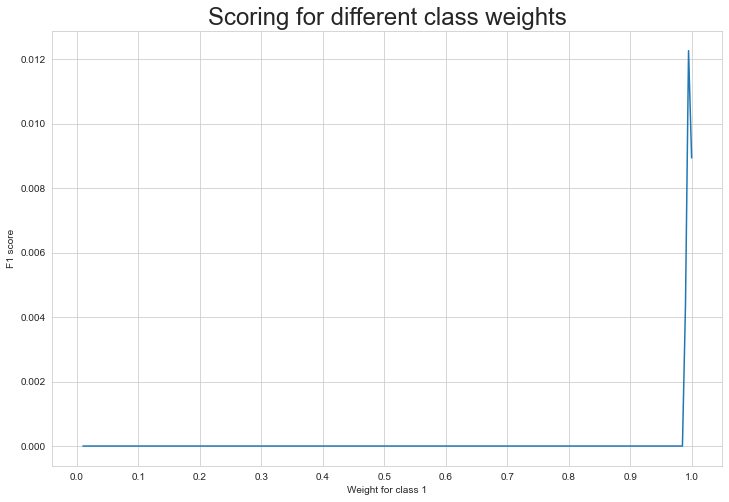

In [28]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [79]:
month["datetime"] = month["datetime"].apply(lambda x: time.strftime("%d", x))
ID = (month['machineID']== 1)
month = month[ID]

/var/folders/09/jl1661rj0md675sp9z1wgqwc0000gn/T/ipykernel_90609/365595252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month["datetime"] = month["datetime"].apply(lambda x: time.strftime("%d", x))


In [70]:
month.count()

datetime     17
machineID    17
volt         17
rotate       17
pressure     17
vibration    17
dtype: int64

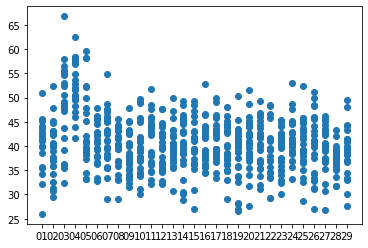

In [94]:
plt.scatter(month.datetime, month.vibration)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7b58503e20>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7b584e9580>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7b55313760>,
 'medians': [<matplotlib.lines.Line2D at 0x7f7b584e9ca0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f7b584dd070>,
 'means': []}

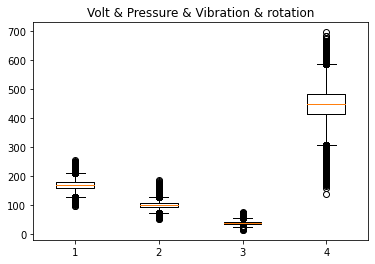

In [112]:
fig1, ax1 = plt.subplots()
ax1.set_title('Volt & Pressure & Vibration & rotation')
ax1.boxplot(df[["volt","pressure","vibration","rotate"]])
#ax1.boxplot(df2["pressure"])
#ax1.boxplot(df2["vibration"])

In [8]:
print("Moyenne de la pression sur les machines : ",df.pressure.mean()/df.pressure.max())
print("Moyenne de la tension sur les machines : ",df.volt.mean()/df.volt.max())
print("Moyenne de la vibration sur les machines : ",df.vibration.mean()/df.vibration.max())

Moyenne de la pression sur les machines :  0.5423908816352501
Moyenne de la tension sur les machines :  0.6693892235466741
Moyenne de la vibration sur les machines :  0.5259075768924533
